In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

from PIL import ImageEnhance
from skimage import data, exposure, img_as_float
from skimage.filters import gaussian

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [4]:
available_segments = [  0,   45,   4300,   52,   50,   41,   39,  60,  37,  58,  56,  4,  11,
       35,  48,  32,  46,  30,  62,  64,  310,  44,  4200,  51,  49,  40,
       38,  59,  36,  57,  55,  47,  31,  23,  61,  63,  630,  15,  770,
       800,  69, 2510, 2520, 2530, 2540, 2550]

In [5]:
available_segments = [  0,   2,   4,   5,   7, 8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  41,   43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  72, 85]

In [6]:
# rest_available = [11,12,50,51]
rest_available = [ 2,   4,   5,   7, 8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  41,   43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  72, 85]

In [7]:
available_segments = [0, 45, 43, 52, 50, 41, 39, 60, 37, 58, 56, 4, 11,
                 35, 48, 32, 46, 30, 62, 64, 44, 42, 51, 49, 40,
                 38, 59, 36, 57, 55, 47, 31, 23, 61, 63, 15, 69]

In [8]:
rest_available = [45, 43, 52, 50, 41, 39, 60, 37, 58, 56, 4, 11,
                 35, 48, 32, 46, 30, 62, 64, 44, 42, 51, 49, 40,
                 38, 59, 36, 57, 55, 47, 31, 23, 61, 63, 15, 69]

In [9]:
len(available_segments)

37

In [10]:
# import dipy
# import matplotlib.pylab as plt

# from dipy.data import get_data
# from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
# from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
# import dipy.align.imwarp as imwarp
# from dipy.viz import regtools

In [11]:
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

In [12]:


# m1 = x[88].reshape([256,256])
# m2 = x[94].reshape([256,256])

# plt.imshow(m1); plt.colorbar(); plt.show()
# plt.imshow(m2); plt.colorbar(); plt.show()

# regtools.overlay_images(m1, m2, 'channel1', 'channel2', 'both channels', 'tmp.png');
# metric = SSDMetric(2)
# level_iters = [200, 100, 50, 25]
# sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)

# mapping = sdr.optimize(m1, m2)

# regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')
# warped_m2 = mapping.transform(m2, 'linear')

# regtools.overlay_images(m1, warped_m2, 'initial m1','Overlay','Warped m2', 'direct_warp_result.png')
# plt.imshow(warped_m2); plt.colorbar(); plt.show()

# plt.imshow(m1-warped_m2); plt.colorbar(); plt.show()
# plt.imshow(m1-m2); plt.colorbar(); plt.show()

In [13]:
num_seg = len(rest_available)+1

In [14]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [15]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [16]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
#         img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
#         image = img_orig.get_data().astype(np.float64)
#         aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
#         aseg_img = aseg_img.get_data().astype(np.float64)
        image = sio.loadmat(image_path)['img']
        aseg_img = sio.loadmat(aseg_path)['img']
        if image.shape[2]>276:
            image = image[:,:,20:276]
            aseg_img = aseg_img[:,:,20:276]
        else:
            image = image[:,:,:256]
            aseg_img = aseg_img[:,:,:256]
        flip = random.random() > 0.5
        angle = random.uniform(-10,10)
        dx = np.round(random.uniform(-15,15))
        dy = np.round(random.uniform(-15,15))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        guassian_flag = random.random() > 0.5
        
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im + 1e-4)
        if self.train_data and guassian_flag:
            sigma_rand = random.uniform(0.65,1.0)
            im_sigma = gaussian(im, sigma = sigma_rand)
            gamma_rand = random.uniform(1.6,2.4)
            im_sigma_gamma = exposure.adjust_gamma(im_sigma, gamma_rand)
            im = (im_sigma_gamma - np.min(im_sigma_gamma))/(np.max(im_sigma_gamma)-np.min(im_sigma_gamma)+1e-4)
        
        
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
#         print(target.shape)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int)
        target_label[rest_available.index(43),:,:] = np.logical_and(target>=100,target%2!=0)
        target_label[rest_available.index(42),:,:] = np.logical_and(target>=100,target%2==0)
#        print(target_label.shape)
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [17]:
rest_available.index(42)

20

In [18]:
# file_names = pd.read_csv("all_complete_path.csv")

In [19]:
# train_subjects = unpickling("train_subject_index")
# val_subjects = unpickling("val_subject_index")
# test_subjects = unpickling("test_subject_index")

In [20]:
# full_train_raw = list(file_names.iloc[train_subjects,2])
# full_train_seg = list(file_names.iloc[train_subjects,3])

# full_val_raw = list(file_names.iloc[val_subjects,2])
# full_val_seg = list(file_names.iloc[val_subjects,3])

# full_test_raw = list(file_names.iloc[test_subjects,2])
# full_test_seg = list(file_names.iloc[test_subjects,3])

In [21]:
path = "/gpfs/data/cbi/hcp/hcp_seg/data_manual_extract/train/"
dir_name = list(os.listdir(path))

In [22]:
dir_name

['1007_3',
 '1011_3',
 '1002_3',
 '1006_3',
 '1010_3',
 '1014_3',
 '1009_3',
 '1013_3',
 '1036_3',
 '1017_3',
 '1008_3',
 '1001_3',
 '1015_3',
 '1000_3',
 '1012_3']

In [23]:
from random import shuffle
shuffle(dir_name)

In [24]:
train_dirs = dir_name[:-3]
val_dirs = dir_name[-3:]

In [25]:
len(train_dirs)+len(val_dirs)

15

In [26]:
train_files_x = []
train_files_y = []
for td in train_dirs:
    for i in range(256):
        train_files_x.append(path+str(td)+"/Data_orig/image"+str(i)+".mat")
        train_files_y.append(path+str(td)+"/Segmentation/image"+str(i)+".mat")

In [27]:
val_files_x = []
val_files_y = []
for vd in val_dirs:
    for i in range(256):
        val_files_x.append(path+str(vd)+"/Data_orig/image"+str(i)+".mat")
        val_files_y.append(path+str(vd)+"/Segmentation/image"+str(i)+".mat")

In [28]:
# rand1 = np.arange(len(full_train_raw))
# np.random.shuffle(rand1)
# rand1 = rand1[:5000]

# rand2 = np.arange(len(val_subjects))
# np.random.shuffle(rand2)
# rand2 = rand2[:1000]

# rand3 = np.arange(len(test_subjects))
# np.random.shuffle(rand3)
# rand3 = rand3[:3]

In [29]:
cd = False
transformed_dataset = {'train': BrainImages(np.array(train_files_x),np.array(train_files_y), train_data= True, flipping = False, coord = cd),
                       'validate': BrainImages(np.array(val_files_x),np.array(val_files_y), coord = cd)
                                               }
bs = 12
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate']}

In [30]:
data = next(iter(dataloader['train']))

In [31]:
data['y'].size()

torch.Size([12, 37, 256, 256])

In [32]:
data['x'].size()

torch.Size([12, 1, 256, 256])

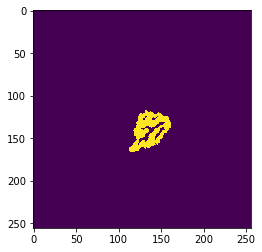

In [33]:
plt.imshow(data['y'][11,1,:,:])

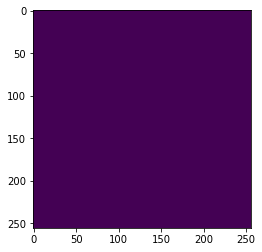

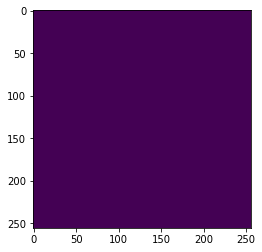

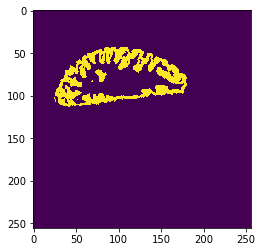

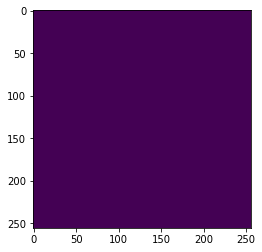

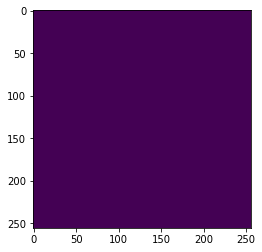

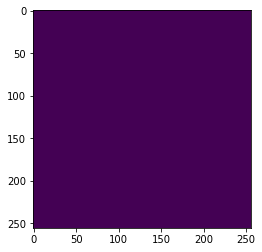

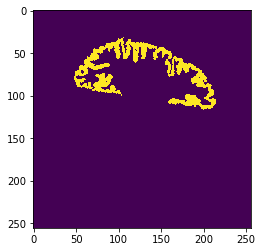

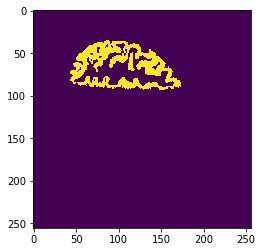

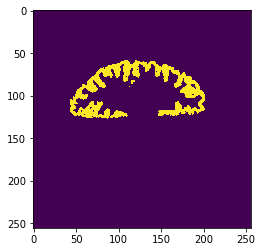

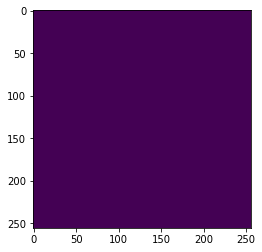

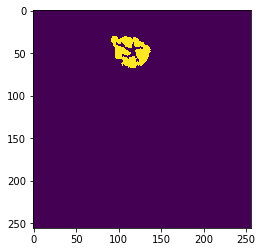

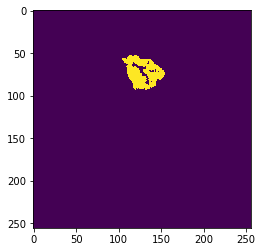

In [34]:
for i in range(bs):
    plt.imshow(data['y'][i,20,:,:])
    plt.show()

In [35]:
# list_arr = []
# for data in dataloader["train"]:
#     y = data['y'].numpy()
#     N,C,_,_ = y.shape
#     sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
#     list_arr.append(sum_arr)
# final_arr = np.concatenate(list_arr,axis = 0)
# freq_class = np.true_divide(final_arr.sum(0),(final_arr!=0).sum(0)*(256*256))
# class_wts = np.median(freq_class)/freq_class
# pickling(class_wts,'new_class_wts_46_seg')

In [36]:
orig_wts = np.array([2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255, 0])
new_wts = np.array([2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  310,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  630,  72,  770,
        800,  85, 2510, 2520, 2530, 2540, 2550, 0])

In [37]:
class_wts = unpickling('manual_weight_36_seg')

In [38]:
# class_wts = class_wts[orig_wts==new_wts]

In [39]:
len(class_wts),num_seg

(37, 37)

In [40]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [41]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [42]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [43]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [44]:
wts_torch = Variable(torch.from_numpy(class_wts)).cuda()

In [45]:
def get_gradient(true):
    true = true.data.cpu().numpy()
    N,C,sh1,sh2 = true.shape
    grads = []
    for i in range(N):
        grad_chan = []
        for j in range(C):
            sx = ndimage.sobel(true_out[i,j],axis=0,mode='constant')
            sy = ndimage.sobel(true_out[i,j],axis=1,mode='constant')
            sobel=np.hypot(sx,sy)
            grad_chan.append(sobel)
        grad_chan = np.vstack(grad_chan)
        grads.append(grad_chan)
    grads = np.vstack(grads)
    grads_mask = torch.from_numpy((np.absolute(grads)>0)).type(torch.cuda.FloatTensor)
    
    return grads_mask.view(N,C,-1)

In [46]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
#     return 40*torch.mean(loss)+we*torch.mean(cel)
    return torch.mean(loss)

In [47]:
def dice_score(true,scores, epsilon = 1e-7):
#     N ,C, sh1, sh2 = true1.size()
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [48]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
                rand_num = np.random.rand()
                if rand_num < 0.90:
                    y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                    y = y[y_mask]
                    x = x[y_mask]
#                 for sel in range(x.size()[0]):
#                     if torch.sum(y[sel,0,:,:]) != 0:
#                         y_sel.append(y[sel,:,:,:])
#                         x_sel.append(x[sel,:,:,:])

#                 try:
#                     y_sel = torch.stack(y_sel)
#                     output_sel = torch.stack(output_sel)
#                 except:
#                     continue
#                 output = model(x)
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                #loss = Variable(dice_loss_2(y_sel, output_sel,wts_torch),requires_grad=True)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)

                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
#                 epoch_score = 0
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
    #                 epoch_score += dice_scores_of_all_class[j][phase][-1]
    #             epoch_score_av = epoch_score / (num_seg - 1)
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
        #print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    pickling(loss_hist,name+'loss_hist')
    pickling(dice_scores_of_all_class,name+'dice_hist')
    
    return model, loss_hist, dice_scores_of_all_class

In [49]:
# model = Unet(in_chan = 1,out_chan = num_seg).cuda()
model = torch.load("pre_trained_new_37_seg_2").cuda()
# model.apply(weights_init)
# model = nn.DataParallel(model)
criterion = dice_loss_2
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [50]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [51]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'fine_tuned_manual_weight_pre_trained_new_37_seg_2',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.0850, Av. Dice Score: 0.9338
Class 0 (DS): 0.8892
Class 1 (DS): 0.8734
Class 2 (DS): 0.9483
Class 3 (DS): 0.9063
Class 4 (DS): 0.8893
Class 5 (DS): 0.8727
Class 6 (DS): 0.9498
Class 7 (DS): 0.9550
Class 8 (DS): 0.9586
Class 9 (DS): 0.9630
Class 10 (DS): 0.9429
Class 11 (DS): 0.8887
Class 12 (DS): 0.9305
Class 13 (DS): 0.9444
Class 14 (DS): 0.9578
Class 15 (DS): 0.9647
Class 16 (DS): 0.9554
Class 17 (DS): 0.9128
Class 18 (DS): 0.9763
Class 19 (DS): 0.8940
Class 20 (DS): 0.8722
Class 21 (DS): 0.9487
Class 22 (DS): 0.8957
Class 23 (DS): 0.8972
Class 24 (DS): 0.8869
Class 25 (DS): 0.9522
Class 26 (DS): 0.9595
Class 27 (DS): 0.9548
Class 28 (DS): 0.9686
Class 29 (DS): 0.9352
Class 30 (DS): 0.9596
Class 31 (DS): 0.9513
Class 32 (DS): 0.9260
Class 33 (DS): 0.9774
Class 34 (DS): 0.9942
Class 35 (DS): 0.9659
----------
Epoch: 0, Phase: validate, epoch loss: 0.0810, Av. Dice Score: 0.9412
Class 0 (DS): 0.9103
Class 1 (DS): 0.8790
Class 2 (DS): 0.9670
Class 3

Epoch: 5, Phase: train, epoch loss: 0.0610, Av. Dice Score: 0.9517
Class 0 (DS): 0.9278
Class 1 (DS): 0.9153
Class 2 (DS): 0.9691
Class 3 (DS): 0.9233
Class 4 (DS): 0.9207
Class 5 (DS): 0.9307
Class 6 (DS): 0.9572
Class 7 (DS): 0.9628
Class 8 (DS): 0.9650
Class 9 (DS): 0.9718
Class 10 (DS): 0.9583
Class 11 (DS): 0.9150
Class 12 (DS): 0.9424
Class 13 (DS): 0.9535
Class 14 (DS): 0.9676
Class 15 (DS): 0.9757
Class 16 (DS): 0.9647
Class 17 (DS): 0.9411
Class 18 (DS): 0.9755
Class 19 (DS): 0.9298
Class 20 (DS): 0.9160
Class 21 (DS): 0.9672
Class 22 (DS): 0.9214
Class 23 (DS): 0.9187
Class 24 (DS): 0.9377
Class 25 (DS): 0.9563
Class 26 (DS): 0.9670
Class 27 (DS): 0.9642
Class 28 (DS): 0.9744
Class 29 (DS): 0.9507
Class 30 (DS): 0.9685
Class 31 (DS): 0.9644
Class 32 (DS): 0.9362
Class 33 (DS): 0.9790
Class 34 (DS): 0.9950
Class 35 (DS): 0.9756
----------
Epoch: 5, Phase: validate, epoch loss: 0.0730, Av. Dice Score: 0.9463
Class 0 (DS): 0.9153
Class 1 (DS): 0.9060
Class 2 (DS): 0.9534
Class 3

Epoch: 10, Phase: train, epoch loss: 0.0552, Av. Dice Score: 0.9551
Class 0 (DS): 0.9287
Class 1 (DS): 0.9237
Class 2 (DS): 0.9707
Class 3 (DS): 0.9345
Class 4 (DS): 0.9266
Class 5 (DS): 0.9354
Class 6 (DS): 0.9620
Class 7 (DS): 0.9676
Class 8 (DS): 0.9673
Class 9 (DS): 0.9700
Class 10 (DS): 0.9585
Class 11 (DS): 0.9233
Class 12 (DS): 0.9496
Class 13 (DS): 0.9571
Class 14 (DS): 0.9684
Class 15 (DS): 0.9784
Class 16 (DS): 0.9681
Class 17 (DS): 0.9423
Class 18 (DS): 0.9795
Class 19 (DS): 0.9322
Class 20 (DS): 0.9195
Class 21 (DS): 0.9690
Class 22 (DS): 0.9283
Class 23 (DS): 0.9275
Class 24 (DS): 0.9399
Class 25 (DS): 0.9552
Class 26 (DS): 0.9691
Class 27 (DS): 0.9695
Class 28 (DS): 0.9735
Class 29 (DS): 0.9515
Class 30 (DS): 0.9702
Class 31 (DS): 0.9686
Class 32 (DS): 0.9419
Class 33 (DS): 0.9822
Class 34 (DS): 0.9940
Class 35 (DS): 0.9786
----------
Epoch: 10, Phase: validate, epoch loss: 0.0734, Av. Dice Score: 0.9486
Class 0 (DS): 0.9173
Class 1 (DS): 0.9040
Class 2 (DS): 0.9628
Class

Epoch: 15, Phase: train, epoch loss: 0.0521, Av. Dice Score: 0.9572
Class 0 (DS): 0.9356
Class 1 (DS): 0.9277
Class 2 (DS): 0.9692
Class 3 (DS): 0.9368
Class 4 (DS): 0.9298
Class 5 (DS): 0.9363
Class 6 (DS): 0.9605
Class 7 (DS): 0.9660
Class 8 (DS): 0.9685
Class 9 (DS): 0.9713
Class 10 (DS): 0.9581
Class 11 (DS): 0.9266
Class 12 (DS): 0.9586
Class 13 (DS): 0.9567
Class 14 (DS): 0.9730
Class 15 (DS): 0.9801
Class 16 (DS): 0.9696
Class 17 (DS): 0.9471
Class 18 (DS): 0.9800
Class 19 (DS): 0.9392
Class 20 (DS): 0.9267
Class 21 (DS): 0.9683
Class 22 (DS): 0.9358
Class 23 (DS): 0.9291
Class 24 (DS): 0.9377
Class 25 (DS): 0.9590
Class 26 (DS): 0.9696
Class 27 (DS): 0.9693
Class 28 (DS): 0.9737
Class 29 (DS): 0.9517
Class 30 (DS): 0.9713
Class 31 (DS): 0.9677
Class 32 (DS): 0.9522
Class 33 (DS): 0.9793
Class 34 (DS): 0.9950
Class 35 (DS): 0.9830
----------
Epoch: 15, Phase: validate, epoch loss: 0.0739, Av. Dice Score: 0.9491
Class 0 (DS): 0.9093
Class 1 (DS): 0.9044
Class 2 (DS): 0.9610
Class

Epoch: 20, Phase: train, epoch loss: 0.0502, Av. Dice Score: 0.9586
Class 0 (DS): 0.9335
Class 1 (DS): 0.9263
Class 2 (DS): 0.9711
Class 3 (DS): 0.9390
Class 4 (DS): 0.9346
Class 5 (DS): 0.9392
Class 6 (DS): 0.9623
Class 7 (DS): 0.9678
Class 8 (DS): 0.9698
Class 9 (DS): 0.9740
Class 10 (DS): 0.9631
Class 11 (DS): 0.9311
Class 12 (DS): 0.9545
Class 13 (DS): 0.9588
Class 14 (DS): 0.9693
Class 15 (DS): 0.9814
Class 16 (DS): 0.9700
Class 17 (DS): 0.9484
Class 18 (DS): 0.9820
Class 19 (DS): 0.9394
Class 20 (DS): 0.9267
Class 21 (DS): 0.9715
Class 22 (DS): 0.9359
Class 23 (DS): 0.9321
Class 24 (DS): 0.9478
Class 25 (DS): 0.9586
Class 26 (DS): 0.9715
Class 27 (DS): 0.9713
Class 28 (DS): 0.9749
Class 29 (DS): 0.9529
Class 30 (DS): 0.9732
Class 31 (DS): 0.9675
Class 32 (DS): 0.9511
Class 33 (DS): 0.9829
Class 34 (DS): 0.9942
Class 35 (DS): 0.9818
----------
Epoch: 20, Phase: validate, epoch loss: 0.0756, Av. Dice Score: 0.9457
Class 0 (DS): 0.9186
Class 1 (DS): 0.8467
Class 2 (DS): 0.9617
Class

Epoch: 25, Phase: train, epoch loss: 0.0491, Av. Dice Score: 0.9597
Class 0 (DS): 0.9362
Class 1 (DS): 0.9321
Class 2 (DS): 0.9709
Class 3 (DS): 0.9406
Class 4 (DS): 0.9354
Class 5 (DS): 0.9362
Class 6 (DS): 0.9634
Class 7 (DS): 0.9697
Class 8 (DS): 0.9720
Class 9 (DS): 0.9732
Class 10 (DS): 0.9638
Class 11 (DS): 0.9300
Class 12 (DS): 0.9562
Class 13 (DS): 0.9577
Class 14 (DS): 0.9710
Class 15 (DS): 0.9829
Class 16 (DS): 0.9713
Class 17 (DS): 0.9527
Class 18 (DS): 0.9812
Class 19 (DS): 0.9404
Class 20 (DS): 0.9284
Class 21 (DS): 0.9771
Class 22 (DS): 0.9387
Class 23 (DS): 0.9343
Class 24 (DS): 0.9455
Class 25 (DS): 0.9634
Class 26 (DS): 0.9695
Class 27 (DS): 0.9694
Class 28 (DS): 0.9767
Class 29 (DS): 0.9567
Class 30 (DS): 0.9715
Class 31 (DS): 0.9666
Class 32 (DS): 0.9547
Class 33 (DS): 0.9841
Class 34 (DS): 0.9947
Class 35 (DS): 0.9800
----------
Epoch: 25, Phase: validate, epoch loss: 0.0734, Av. Dice Score: 0.9469
Class 0 (DS): 0.9177
Class 1 (DS): 0.9092
Class 2 (DS): 0.9668
Class

In [52]:
pickle.dump(loss_hist,open("fine_tuned_manual_weight_pre_trained_new_37_seg_2_loss1",'wb'))

In [53]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [54]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'fine_tuned_manual_weight_pre_trained_new_37_seg_3',num_seg = num_seg, num_epochs = 10,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.0476, Av. Dice Score: 0.9606
Class 0 (DS): 0.9370
Class 1 (DS): 0.9308
Class 2 (DS): 0.9740
Class 3 (DS): 0.9436
Class 4 (DS): 0.9371
Class 5 (DS): 0.9361
Class 6 (DS): 0.9629
Class 7 (DS): 0.9748
Class 8 (DS): 0.9706
Class 9 (DS): 0.9741
Class 10 (DS): 0.9640
Class 11 (DS): 0.9339
Class 12 (DS): 0.9507
Class 13 (DS): 0.9639
Class 14 (DS): 0.9701
Class 15 (DS): 0.9819
Class 16 (DS): 0.9730
Class 17 (DS): 0.9517
Class 18 (DS): 0.9785
Class 19 (DS): 0.9406
Class 20 (DS): 0.9325
Class 21 (DS): 0.9754
Class 22 (DS): 0.9410
Class 23 (DS): 0.9349
Class 24 (DS): 0.9447
Class 25 (DS): 0.9636
Class 26 (DS): 0.9770
Class 27 (DS): 0.9701
Class 28 (DS): 0.9767
Class 29 (DS): 0.9562
Class 30 (DS): 0.9737
Class 31 (DS): 0.9692
Class 32 (DS): 0.9550
Class 33 (DS): 0.9820
Class 34 (DS): 0.9952
Class 35 (DS): 0.9842
----------
Epoch: 0, Phase: validate, epoch loss: 0.0754, Av. Dice Score: 0.9417
Class 0 (DS): 0.9140
Class 1 (DS): 0.8263
Class 2 (DS): 0.9555
Class 3

Epoch: 5, Phase: train, epoch loss: 0.0466, Av. Dice Score: 0.9611
Class 0 (DS): 0.9401
Class 1 (DS): 0.9351
Class 2 (DS): 0.9745
Class 3 (DS): 0.9488
Class 4 (DS): 0.9361
Class 5 (DS): 0.9374
Class 6 (DS): 0.9616
Class 7 (DS): 0.9725
Class 8 (DS): 0.9713
Class 9 (DS): 0.9758
Class 10 (DS): 0.9666
Class 11 (DS): 0.9360
Class 12 (DS): 0.9524
Class 13 (DS): 0.9609
Class 14 (DS): 0.9702
Class 15 (DS): 0.9832
Class 16 (DS): 0.9722
Class 17 (DS): 0.9548
Class 18 (DS): 0.9822
Class 19 (DS): 0.9381
Class 20 (DS): 0.9290
Class 21 (DS): 0.9771
Class 22 (DS): 0.9395
Class 23 (DS): 0.9342
Class 24 (DS): 0.9434
Class 25 (DS): 0.9641
Class 26 (DS): 0.9763
Class 27 (DS): 0.9697
Class 28 (DS): 0.9748
Class 29 (DS): 0.9588
Class 30 (DS): 0.9730
Class 31 (DS): 0.9668
Class 32 (DS): 0.9579
Class 33 (DS): 0.9852
Class 34 (DS): 0.9946
Class 35 (DS): 0.9857
----------
Epoch: 5, Phase: validate, epoch loss: 0.0876, Av. Dice Score: 0.9219
Class 0 (DS): 0.9141
Class 1 (DS): 0.7907
Class 2 (DS): 0.9661
Class 3

In [50]:
pickle.dump(loss_hist,open("fine_tuned_pre_trained_new_37_seg_2_loss2",'wb'))

In [51]:
optimizer = optim.Adam(model.parameters(),lr = 5e-6)

In [52]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'fine_tuned_pre_trained_new_37_seg_2_3',num_seg = num_seg, num_epochs = 10,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.0419, Av. Dice Score: 0.9651
Class 0 (DS): 0.9465
Class 1 (DS): 0.9414
Class 2 (DS): 0.9748
Class 3 (DS): 0.9453
Class 4 (DS): 0.9481
Class 5 (DS): 0.9451
Class 6 (DS): 0.9647
Class 7 (DS): 0.9757
Class 8 (DS): 0.9736
Class 9 (DS): 0.9728
Class 10 (DS): 0.9674
Class 11 (DS): 0.9428
Class 12 (DS): 0.9645
Class 13 (DS): 0.9670
Class 14 (DS): 0.9771
Class 15 (DS): 0.9853
Class 16 (DS): 0.9755
Class 17 (DS): 0.9590
Class 18 (DS): 0.9862
Class 19 (DS): 0.9479
Class 20 (DS): 0.9398
Class 21 (DS): 0.9777
Class 22 (DS): 0.9496
Class 23 (DS): 0.9426
Class 24 (DS): 0.9479
Class 25 (DS): 0.9648
Class 26 (DS): 0.9778
Class 27 (DS): 0.9708
Class 28 (DS): 0.9785
Class 29 (DS): 0.9618
Class 30 (DS): 0.9758
Class 31 (DS): 0.9727
Class 32 (DS): 0.9599
Class 33 (DS): 0.9823
Class 34 (DS): 0.9948
Class 35 (DS): 0.9860
----------
Epoch: 0, Phase: validate, epoch loss: 0.0640, Av. Dice Score: 0.9515
Class 0 (DS): 0.9226
Class 1 (DS): 0.9184
Class 2 (DS): 0.9756
Class 3

Epoch: 5, Phase: train, epoch loss: 0.0427, Av. Dice Score: 0.9647
Class 0 (DS): 0.9497
Class 1 (DS): 0.9394
Class 2 (DS): 0.9771
Class 3 (DS): 0.9491
Class 4 (DS): 0.9469
Class 5 (DS): 0.9460
Class 6 (DS): 0.9640
Class 7 (DS): 0.9734
Class 8 (DS): 0.9756
Class 9 (DS): 0.9746
Class 10 (DS): 0.9694
Class 11 (DS): 0.9434
Class 12 (DS): 0.9653
Class 13 (DS): 0.9649
Class 14 (DS): 0.9739
Class 15 (DS): 0.9860
Class 16 (DS): 0.9752
Class 17 (DS): 0.9550
Class 18 (DS): 0.9840
Class 19 (DS): 0.9447
Class 20 (DS): 0.9381
Class 21 (DS): 0.9772
Class 22 (DS): 0.9479
Class 23 (DS): 0.9429
Class 24 (DS): 0.9472
Class 25 (DS): 0.9651
Class 26 (DS): 0.9763
Class 27 (DS): 0.9725
Class 28 (DS): 0.9778
Class 29 (DS): 0.9614
Class 30 (DS): 0.9728
Class 31 (DS): 0.9706
Class 32 (DS): 0.9556
Class 33 (DS): 0.9844
Class 34 (DS): 0.9952
Class 35 (DS): 0.9860
----------
Epoch: 5, Phase: validate, epoch loss: 0.0615, Av. Dice Score: 0.9554
Class 0 (DS): 0.9235
Class 1 (DS): 0.9210
Class 2 (DS): 0.9774
Class 3

--------------------------------------------------
Training complete in 35m 12s
Best val dice loss: 0.058805, Best Average DS: 0.956726


In [53]:
pickle.dump(loss_hist,open("fine_tuned_pre_trained_new_37_seg_2_loss3",'wb'))

In [35]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [36]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
#     cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
#     return 40*torch.mean(loss)+we*torch.mean(cel)
    return torch.mean(loss)

In [37]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'pre_trained_lr_5e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.0680, Av. Dice Score: 0.9583
Class 0 (DS): 0.9111
Class 1 (DS): 0.9705
Class 2 (DS): 0.9600
Class 3 (DS): 0.9164
Class 4 (DS): 0.9357
Class 5 (DS): 0.9716
Class 6 (DS): 0.9677
Class 7 (DS): 0.9680
Class 8 (DS): 0.9482
Class 9 (DS): 0.9667
Class 10 (DS): 0.9317
Class 11 (DS): 0.9499
Class 12 (DS): 0.9586
Class 13 (DS): 0.9699
Class 14 (DS): 0.9674
Class 15 (DS): 0.9656
Class 16 (DS): 0.9577
Class 17 (DS): 0.9841
Class 18 (DS): 0.9132
Class 19 (DS): 0.9669
Class 20 (DS): 0.9649
Class 21 (DS): 0.9191
Class 22 (DS): 0.9398
Class 23 (DS): 0.9723
Class 24 (DS): 0.9654
Class 25 (DS): 0.9698
Class 26 (DS): 0.9626
Class 27 (DS): 0.9586
Class 28 (DS): 0.9670
Class 29 (DS): 0.9649
Class 30 (DS): 0.9643
Class 31 (DS): 0.9855
Class 32 (DS): 0.9870
Class 33 (DS): 0.9786
----------
Epoch: 0, Phase: validate, epoch loss: 0.0758, Av. Dice Score: 0.9463
Class 0 (DS): 0.9083
Class 1 (DS): 0.9657
Class 2 (DS): 0.9417
Class 3 (DS): 0.8958
Class 4 (DS): 0.9379
Class 5 (

Epoch: 5, Phase: validate, epoch loss: 0.0671, Av. Dice Score: 0.9531
Class 0 (DS): 0.9177
Class 1 (DS): 0.9654
Class 2 (DS): 0.9507
Class 3 (DS): 0.9075
Class 4 (DS): 0.9426
Class 5 (DS): 0.9660
Class 6 (DS): 0.9571
Class 7 (DS): 0.9575
Class 8 (DS): 0.9391
Class 9 (DS): 0.9583
Class 10 (DS): 0.9405
Class 11 (DS): 0.9453
Class 12 (DS): 0.9538
Class 13 (DS): 0.9732
Class 14 (DS): 0.9508
Class 15 (DS): 0.9557
Class 16 (DS): 0.9534
Class 17 (DS): 0.9883
Class 18 (DS): 0.9247
Class 19 (DS): 0.9548
Class 20 (DS): 0.9575
Class 21 (DS): 0.9092
Class 22 (DS): 0.9428
Class 23 (DS): 0.9677
Class 24 (DS): 0.9550
Class 25 (DS): 0.9564
Class 26 (DS): 0.9503
Class 27 (DS): 0.9495
Class 28 (DS): 0.9802
Class 29 (DS): 0.9451
Class 30 (DS): 0.9531
Class 31 (DS): 0.9839
Class 32 (DS): 0.9899
Class 33 (DS): 0.9626
----------
Epoch: 6, Phase: train, epoch loss: 0.0597, Av. Dice Score: 0.9612
Class 0 (DS): 0.9210
Class 1 (DS): 0.9732
Class 2 (DS): 0.9677
Class 3 (DS): 0.9183
Class 4 (DS): 0.9400
Class 5 (

Epoch: 11, Phase: train, epoch loss: 0.0567, Av. Dice Score: 0.9630
Class 0 (DS): 0.9256
Class 1 (DS): 0.9736
Class 2 (DS): 0.9686
Class 3 (DS): 0.9205
Class 4 (DS): 0.9405
Class 5 (DS): 0.9717
Class 6 (DS): 0.9713
Class 7 (DS): 0.9693
Class 8 (DS): 0.9578
Class 9 (DS): 0.9690
Class 10 (DS): 0.9445
Class 11 (DS): 0.9540
Class 12 (DS): 0.9640
Class 13 (DS): 0.9756
Class 14 (DS): 0.9710
Class 15 (DS): 0.9681
Class 16 (DS): 0.9610
Class 17 (DS): 0.9857
Class 18 (DS): 0.9300
Class 19 (DS): 0.9713
Class 20 (DS): 0.9717
Class 21 (DS): 0.9226
Class 22 (DS): 0.9431
Class 23 (DS): 0.9765
Class 24 (DS): 0.9686
Class 25 (DS): 0.9714
Class 26 (DS): 0.9628
Class 27 (DS): 0.9645
Class 28 (DS): 0.9744
Class 29 (DS): 0.9685
Class 30 (DS): 0.9675
Class 31 (DS): 0.9867
Class 32 (DS): 0.9886
Class 33 (DS): 0.9821
----------
Epoch: 11, Phase: validate, epoch loss: 0.0671, Av. Dice Score: 0.9526
Class 0 (DS): 0.9197
Class 1 (DS): 0.9639
Class 2 (DS): 0.9445
Class 3 (DS): 0.9051
Class 4 (DS): 0.9484
Class 5

Epoch: 16, Phase: validate, epoch loss: 0.0674, Av. Dice Score: 0.9511
Class 0 (DS): 0.9183
Class 1 (DS): 0.9675
Class 2 (DS): 0.9404
Class 3 (DS): 0.8980
Class 4 (DS): 0.9391
Class 5 (DS): 0.9633
Class 6 (DS): 0.9557
Class 7 (DS): 0.9506
Class 8 (DS): 0.9336
Class 9 (DS): 0.9568
Class 10 (DS): 0.9337
Class 11 (DS): 0.9378
Class 12 (DS): 0.9517
Class 13 (DS): 0.9739
Class 14 (DS): 0.9561
Class 15 (DS): 0.9485
Class 16 (DS): 0.9483
Class 17 (DS): 0.9866
Class 18 (DS): 0.9270
Class 19 (DS): 0.9648
Class 20 (DS): 0.9506
Class 21 (DS): 0.8899
Class 22 (DS): 0.9383
Class 23 (DS): 0.9681
Class 24 (DS): 0.9559
Class 25 (DS): 0.9567
Class 26 (DS): 0.9545
Class 27 (DS): 0.9516
Class 28 (DS): 0.9792
Class 29 (DS): 0.9443
Class 30 (DS): 0.9565
Class 31 (DS): 0.9844
Class 32 (DS): 0.9891
Class 33 (DS): 0.9658
----------
Epoch: 17, Phase: train, epoch loss: 0.0560, Av. Dice Score: 0.9630
Class 0 (DS): 0.9234
Class 1 (DS): 0.9716
Class 2 (DS): 0.9688
Class 3 (DS): 0.9234
Class 4 (DS): 0.9389
Class 5

Epoch: 22, Phase: train, epoch loss: 0.0541, Av. Dice Score: 0.9640
Class 0 (DS): 0.9273
Class 1 (DS): 0.9744
Class 2 (DS): 0.9695
Class 3 (DS): 0.9248
Class 4 (DS): 0.9428
Class 5 (DS): 0.9720
Class 6 (DS): 0.9722
Class 7 (DS): 0.9722
Class 8 (DS): 0.9615
Class 9 (DS): 0.9727
Class 10 (DS): 0.9442
Class 11 (DS): 0.9560
Class 12 (DS): 0.9630
Class 13 (DS): 0.9761
Class 14 (DS): 0.9720
Class 15 (DS): 0.9699
Class 16 (DS): 0.9605
Class 17 (DS): 0.9874
Class 18 (DS): 0.9303
Class 19 (DS): 0.9722
Class 20 (DS): 0.9731
Class 21 (DS): 0.9241
Class 22 (DS): 0.9456
Class 23 (DS): 0.9740
Class 24 (DS): 0.9691
Class 25 (DS): 0.9720
Class 26 (DS): 0.9639
Class 27 (DS): 0.9664
Class 28 (DS): 0.9759
Class 29 (DS): 0.9673
Class 30 (DS): 0.9682
Class 31 (DS): 0.9877
Class 32 (DS): 0.9875
Class 33 (DS): 0.9819
----------
Epoch: 22, Phase: validate, epoch loss: 0.0678, Av. Dice Score: 0.9512
Class 0 (DS): 0.9187
Class 1 (DS): 0.9572
Class 2 (DS): 0.9298
Class 3 (DS): 0.9004
Class 4 (DS): 0.9413
Class 5

Epoch: 27, Phase: validate, epoch loss: 0.0670, Av. Dice Score: 0.9514
Class 0 (DS): 0.9210
Class 1 (DS): 0.9670
Class 2 (DS): 0.9440
Class 3 (DS): 0.9109
Class 4 (DS): 0.9385
Class 5 (DS): 0.9649
Class 6 (DS): 0.9536
Class 7 (DS): 0.9523
Class 8 (DS): 0.9271
Class 9 (DS): 0.9537
Class 10 (DS): 0.9351
Class 11 (DS): 0.9469
Class 12 (DS): 0.9511
Class 13 (DS): 0.9738
Class 14 (DS): 0.9554
Class 15 (DS): 0.9501
Class 16 (DS): 0.9514
Class 17 (DS): 0.9883
Class 18 (DS): 0.9270
Class 19 (DS): 0.9484
Class 20 (DS): 0.9519
Class 21 (DS): 0.9130
Class 22 (DS): 0.9420
Class 23 (DS): 0.9652
Class 24 (DS): 0.9524
Class 25 (DS): 0.9608
Class 26 (DS): 0.9505
Class 27 (DS): 0.9465
Class 28 (DS): 0.9799
Class 29 (DS): 0.9444
Class 30 (DS): 0.9472
Class 31 (DS): 0.9807
Class 32 (DS): 0.9885
Class 33 (DS): 0.9645
----------
Epoch: 28, Phase: train, epoch loss: 0.0526, Av. Dice Score: 0.9652
Class 0 (DS): 0.9263
Class 1 (DS): 0.9759
Class 2 (DS): 0.9750
Class 3 (DS): 0.9257
Class 4 (DS): 0.9439
Class 5

In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 1e-5)

In [ ]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_3_dnc_then_d_lr_1e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

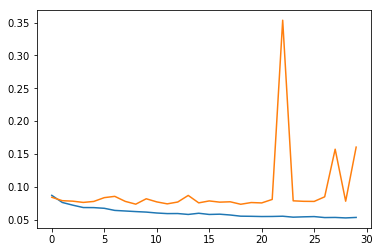

In [46]:
plt.plot(loss_hist['train'])
plt.plot(loss_hist['validate'])

In [47]:
pickle.dump(loss_hist,open("exp_3_dnc_then_d_lr_1e-5_loss1",'wb'))

In [ ]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2,we = 0.05):
#     N, C, sh1, sh2 = true1.size()
    
#     true = []
#     scores = []
#     for c in range(N):
#         if not torch.sum(true1[c,1:,:,:])==0:
#             true.append(true1[c,:,:,:])
#             scores.append(scores1[c,:,:,:])
#     try:
#         true = torch.stack(true)
#         scores = torch.stack(scores)
#     except:
#         return -1
    
    
    
    N, C, sh1, sh2 = true.size()
#     grad_mask = get_gradient(true)
#     grad_mask = grad_mask.view(N,C,-1)
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
#     mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
#     wts = wts/(torch.sum(wts,dim = 1)[:,None])
#     print(wts)
    grad_wts = torch.max(mean)
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
#     cel = -torch.sum(wts * torch.sum(true*torch.log(preds),dim = 2),dim = 1)
#     grad_loss = -torch.sum(2*grad_wts * torch.sum(grad_mask*torch.log(preds),dim = 2),dim = 1)
#     return 40*torch.mean(loss)+we*torch.mean(cel)
    return torch.mean(loss)

In [ ]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'exp_4_dnc_then_d_lr_1e-5',num_seg = num_seg, num_epochs = 30,\
                                         every = 1, print_all_ds = True)

In [ ]:
#most recent model
#guassian_gamma_v1_4

In [38]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [39]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [40]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    output = model(x)
    for i in range(bs):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.unsqueeze(1)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


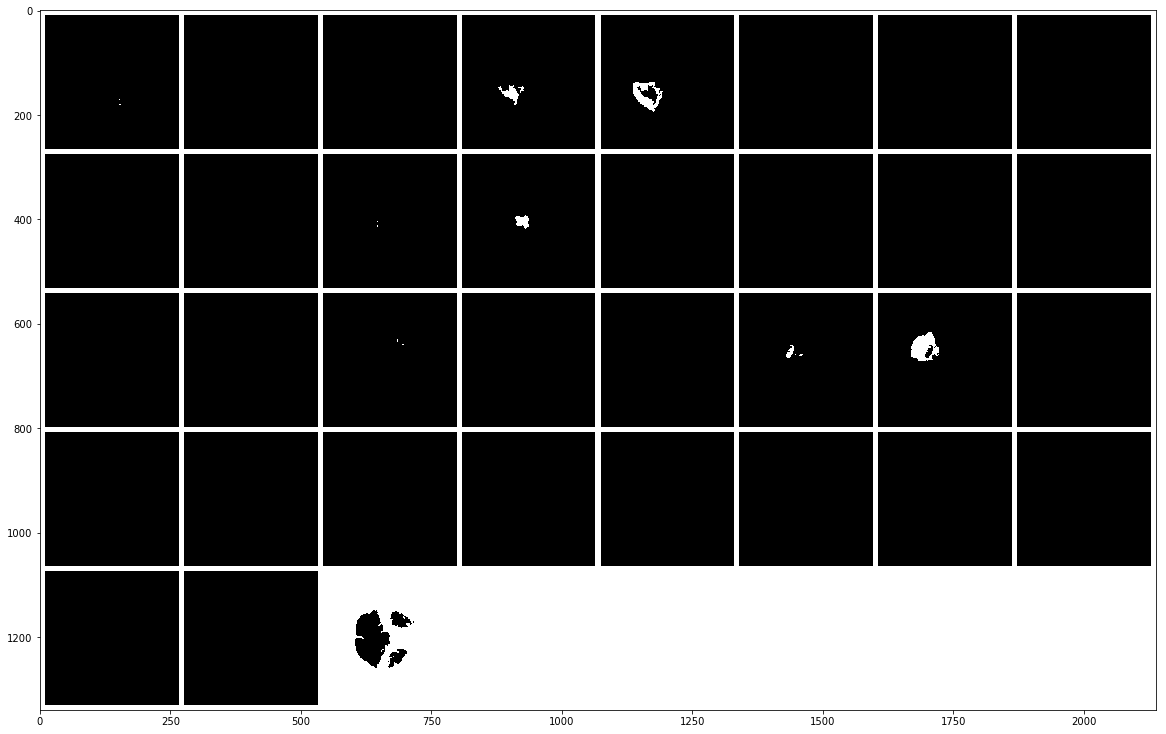

----------------------------------------------------------------------------------------------------
Prediction


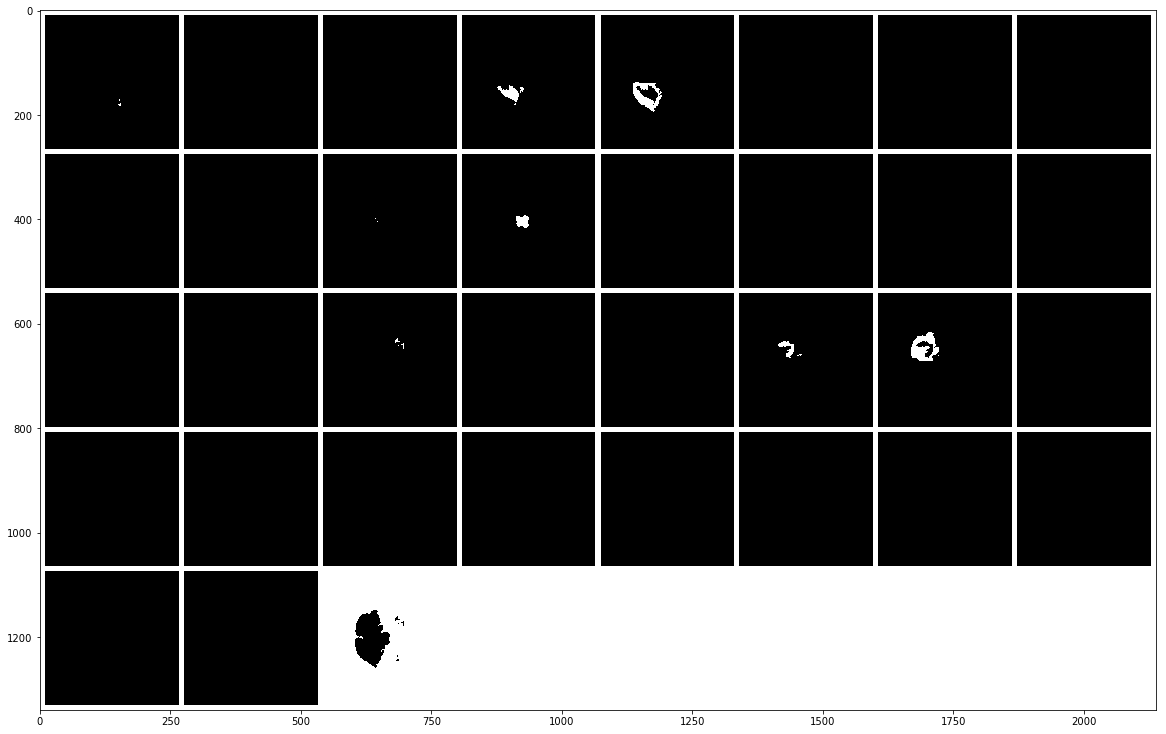

----------------------------------------------------------------------------------------------------
Ground Truth


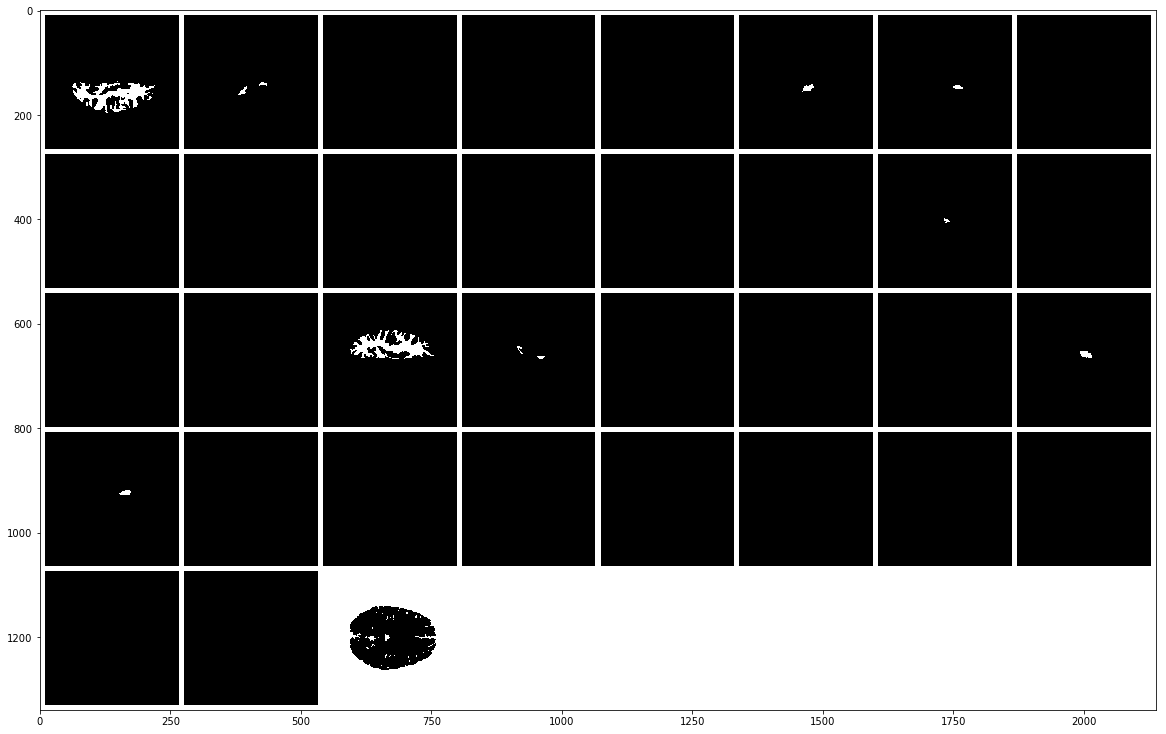

----------------------------------------------------------------------------------------------------
Prediction


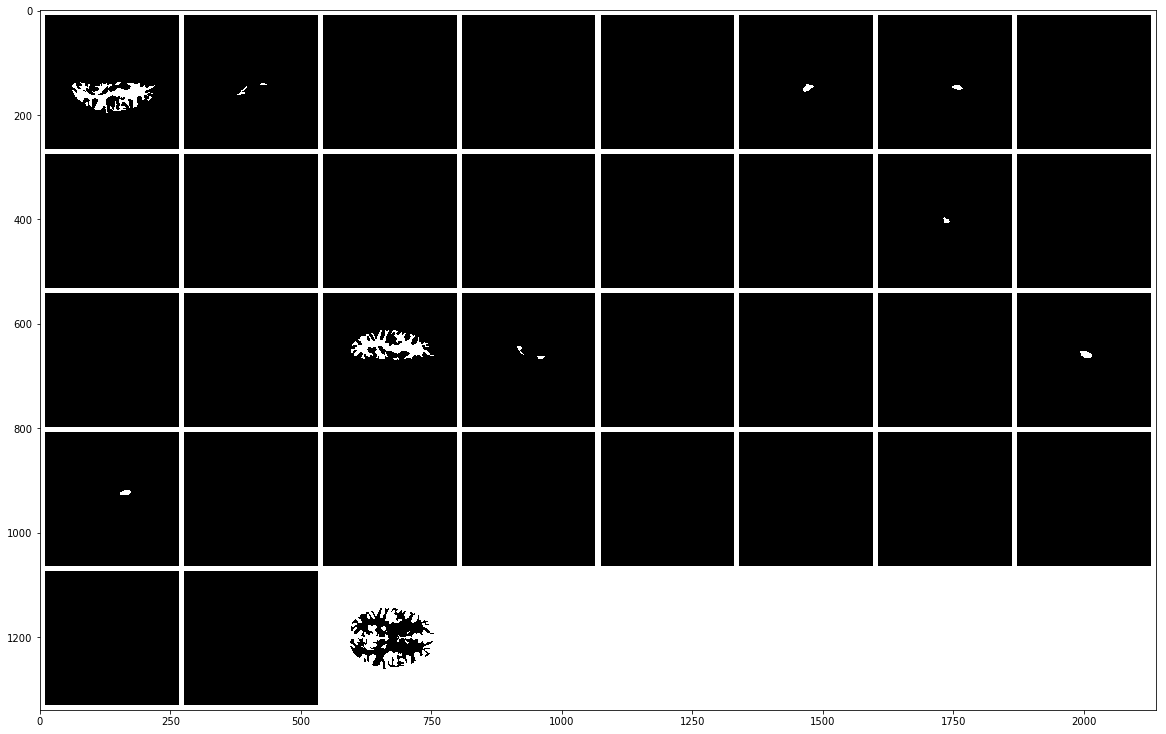

----------------------------------------------------------------------------------------------------
Ground Truth


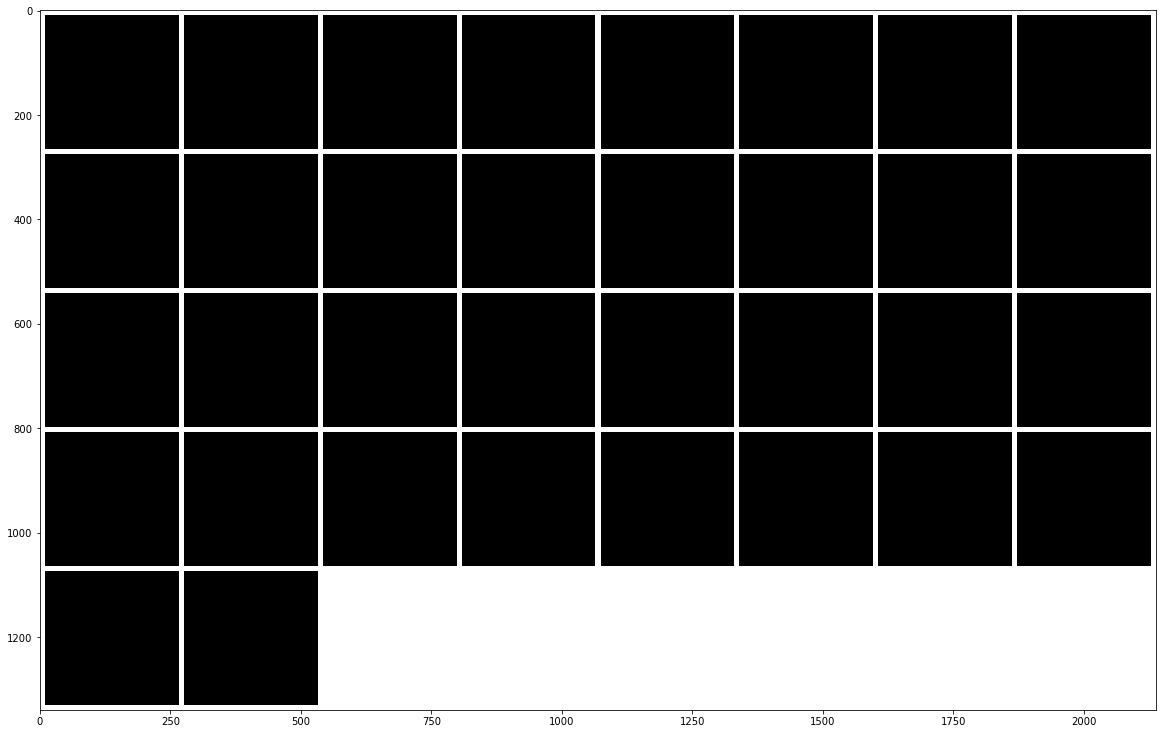

----------------------------------------------------------------------------------------------------
Prediction


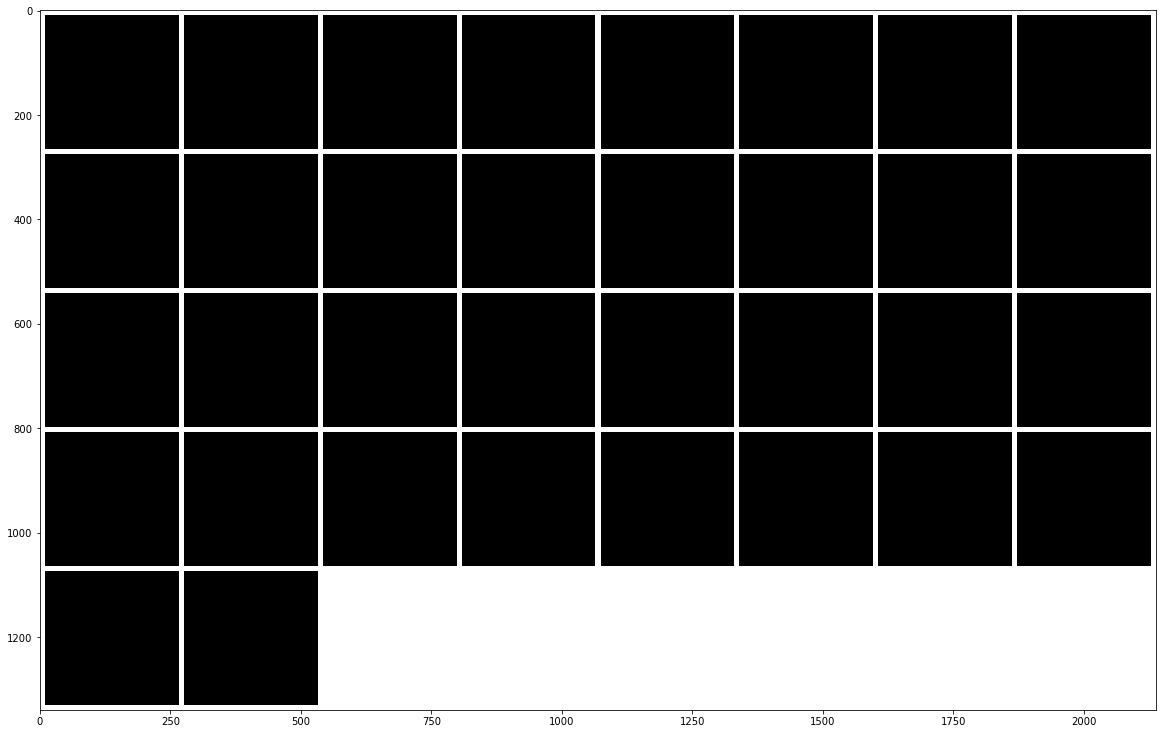

----------------------------------------------------------------------------------------------------
Ground Truth


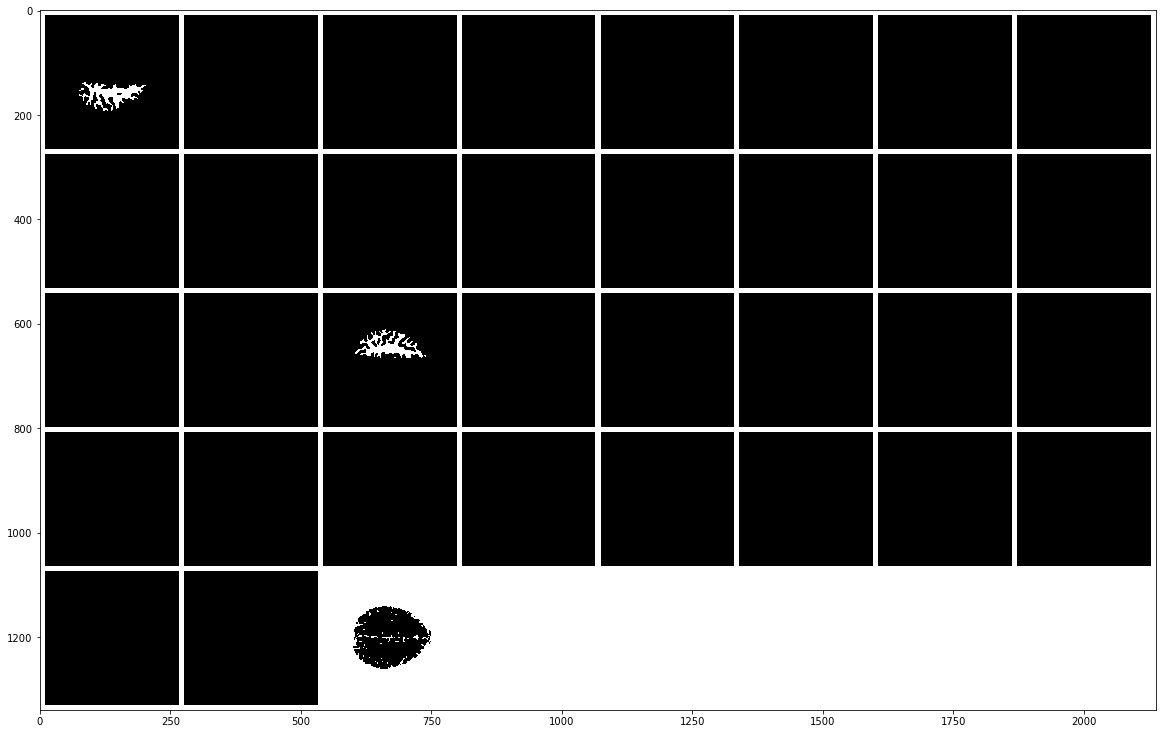

----------------------------------------------------------------------------------------------------
Prediction


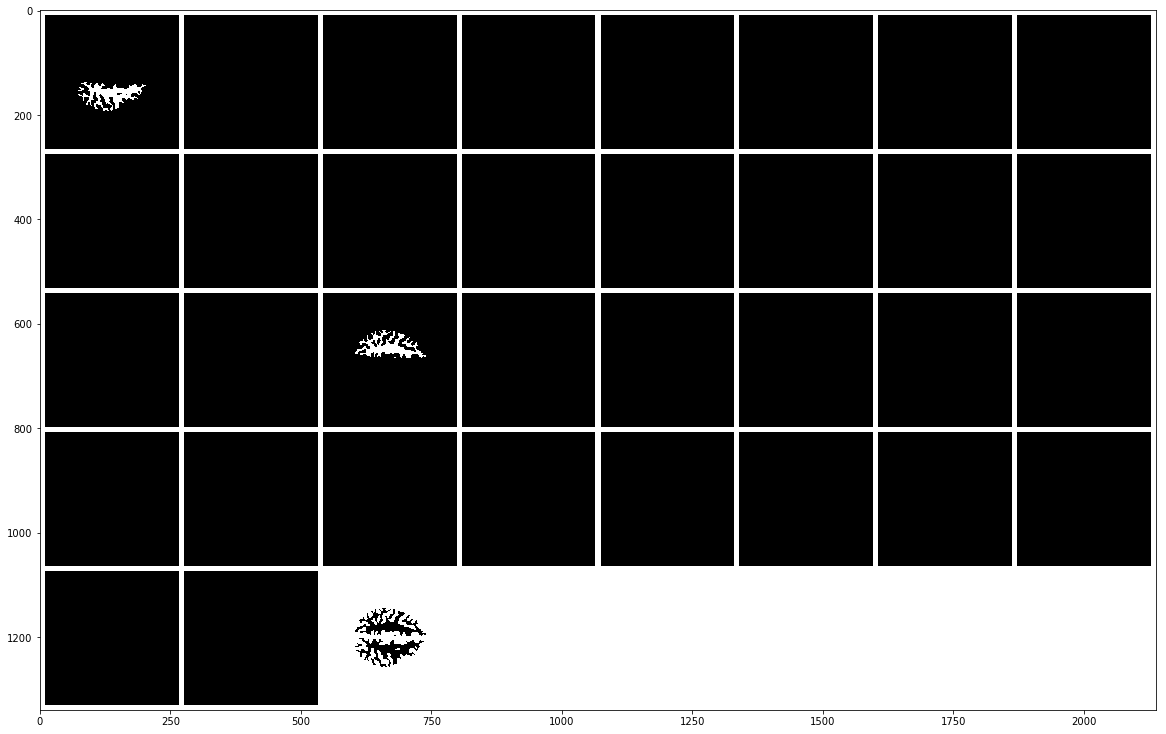

----------------------------------------------------------------------------------------------------
Ground Truth


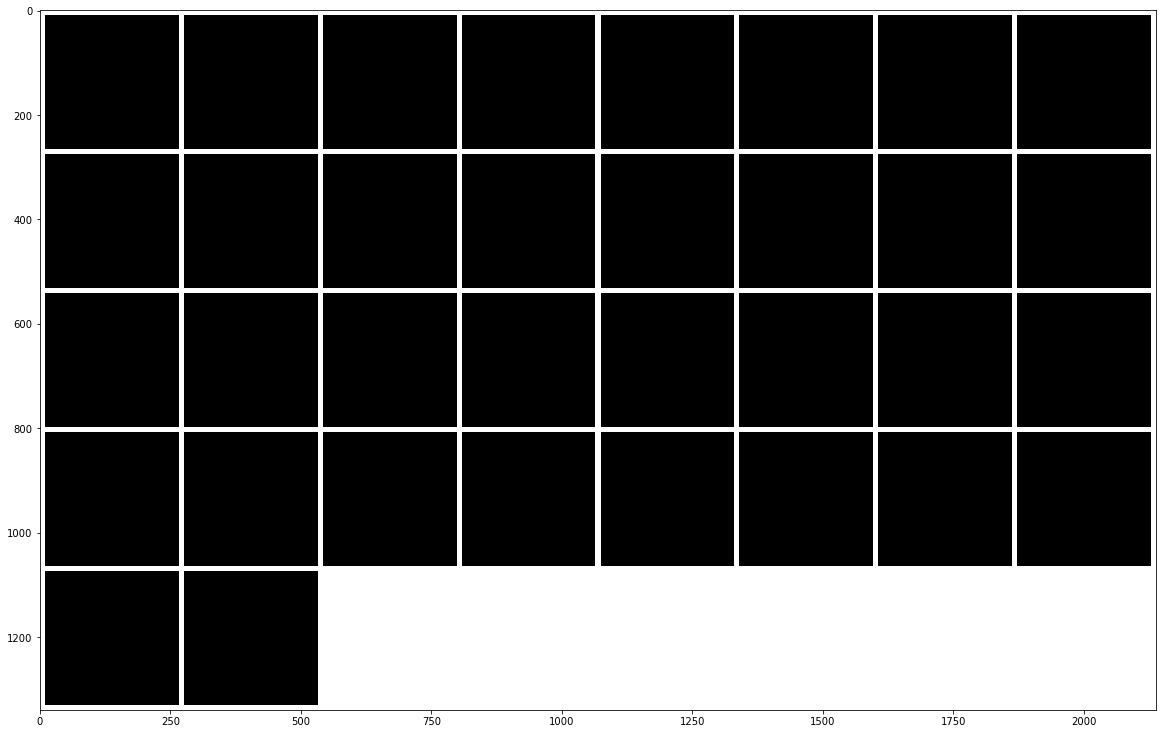

----------------------------------------------------------------------------------------------------
Prediction


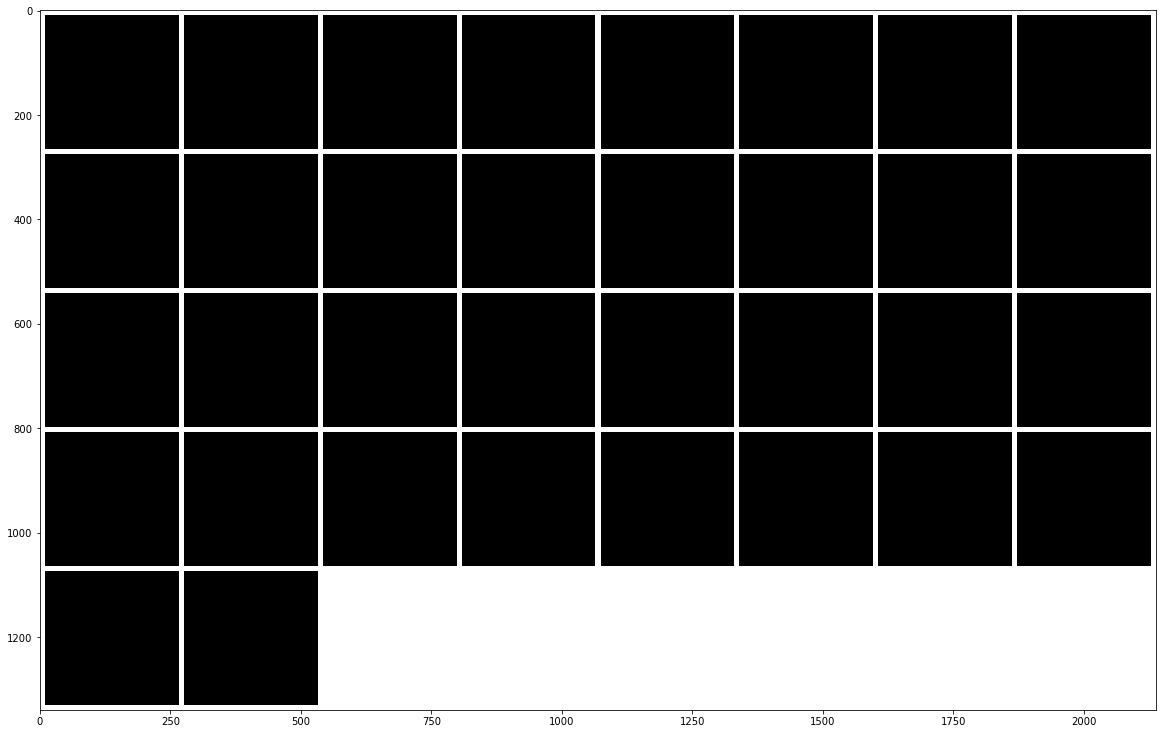

----------------------------------------------------------------------------------------------------
Ground Truth


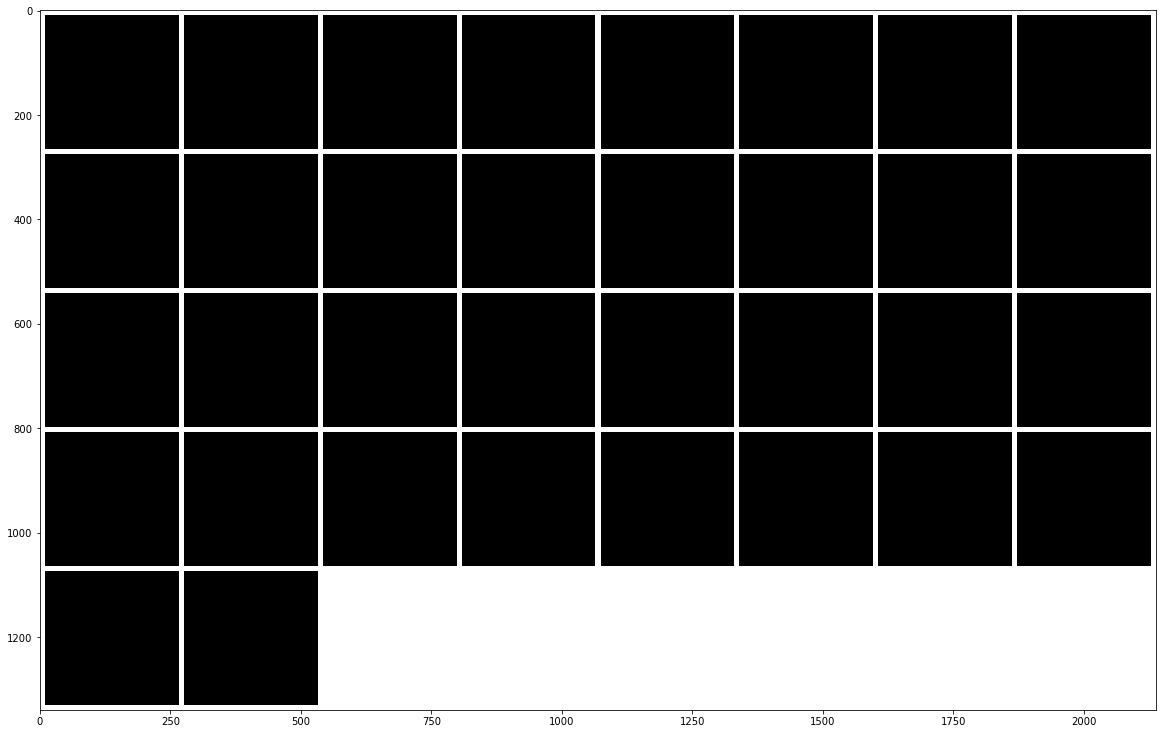

----------------------------------------------------------------------------------------------------
Prediction


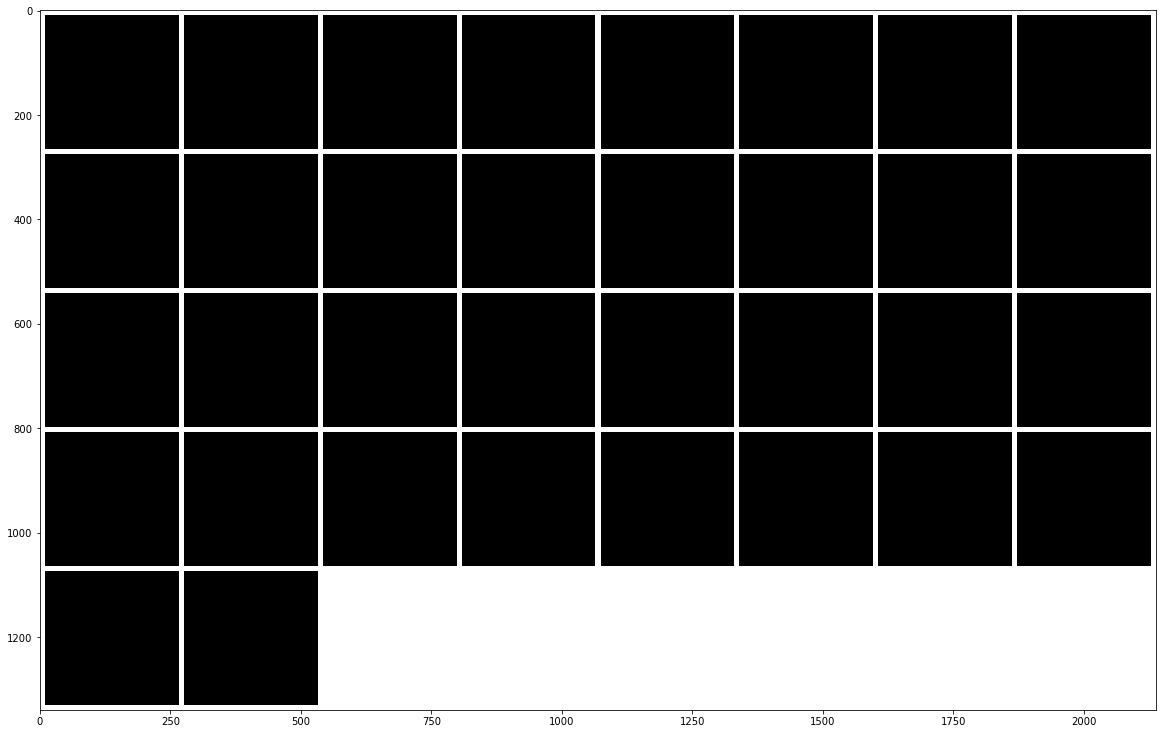

----------------------------------------------------------------------------------------------------
Ground Truth


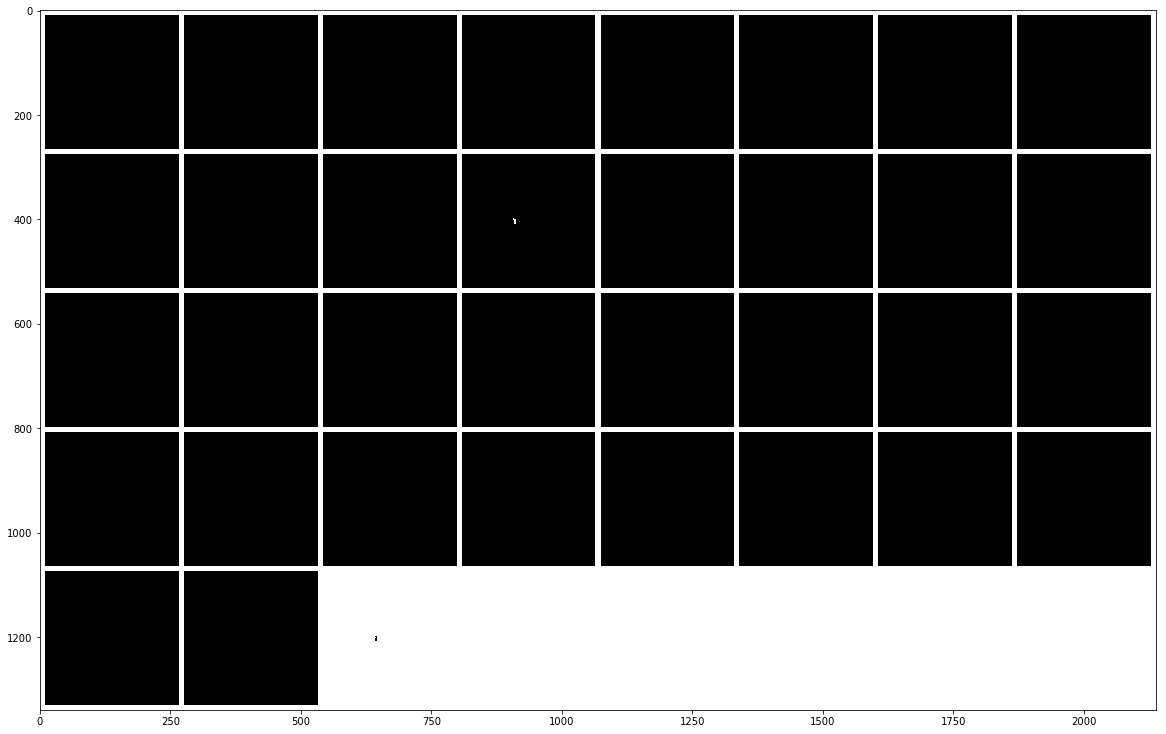

----------------------------------------------------------------------------------------------------
Prediction


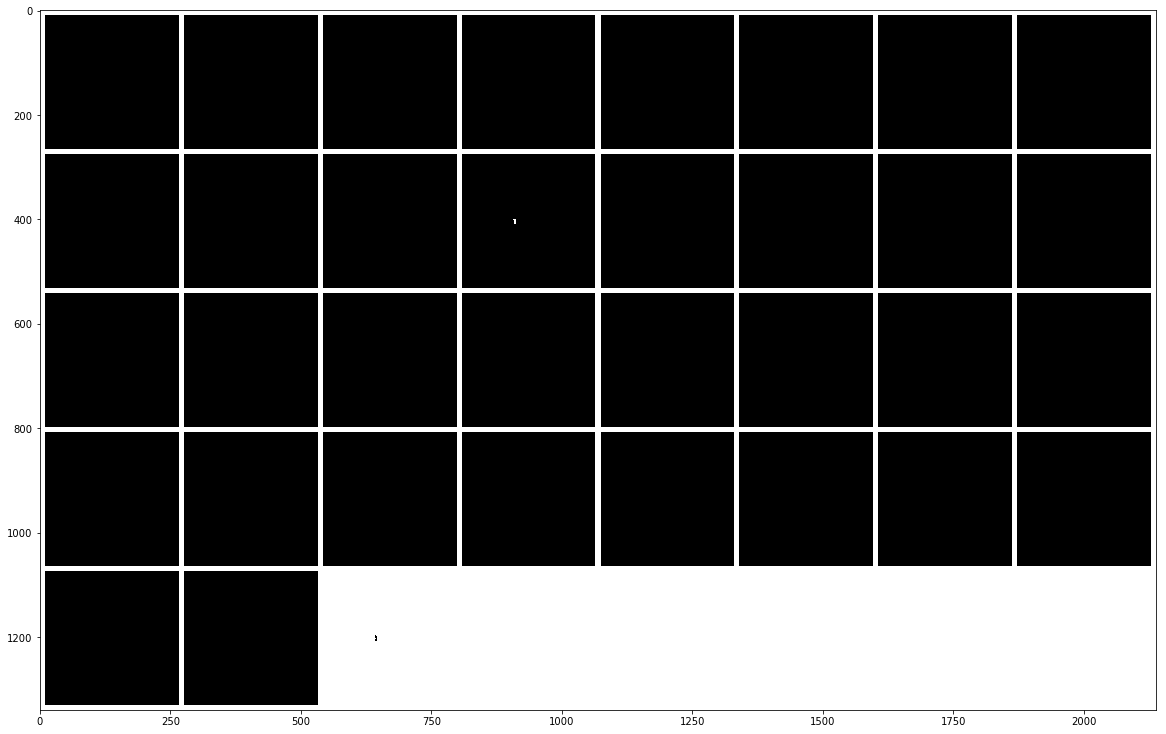

----------------------------------------------------------------------------------------------------
Ground Truth


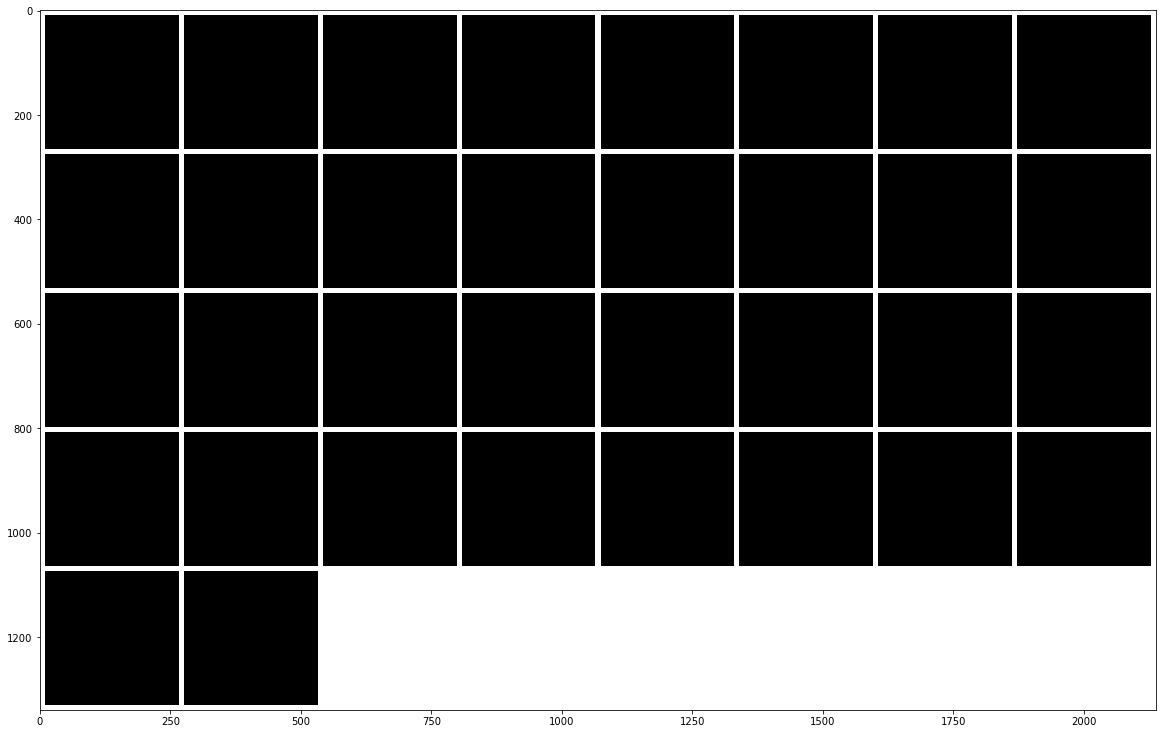

----------------------------------------------------------------------------------------------------
Prediction


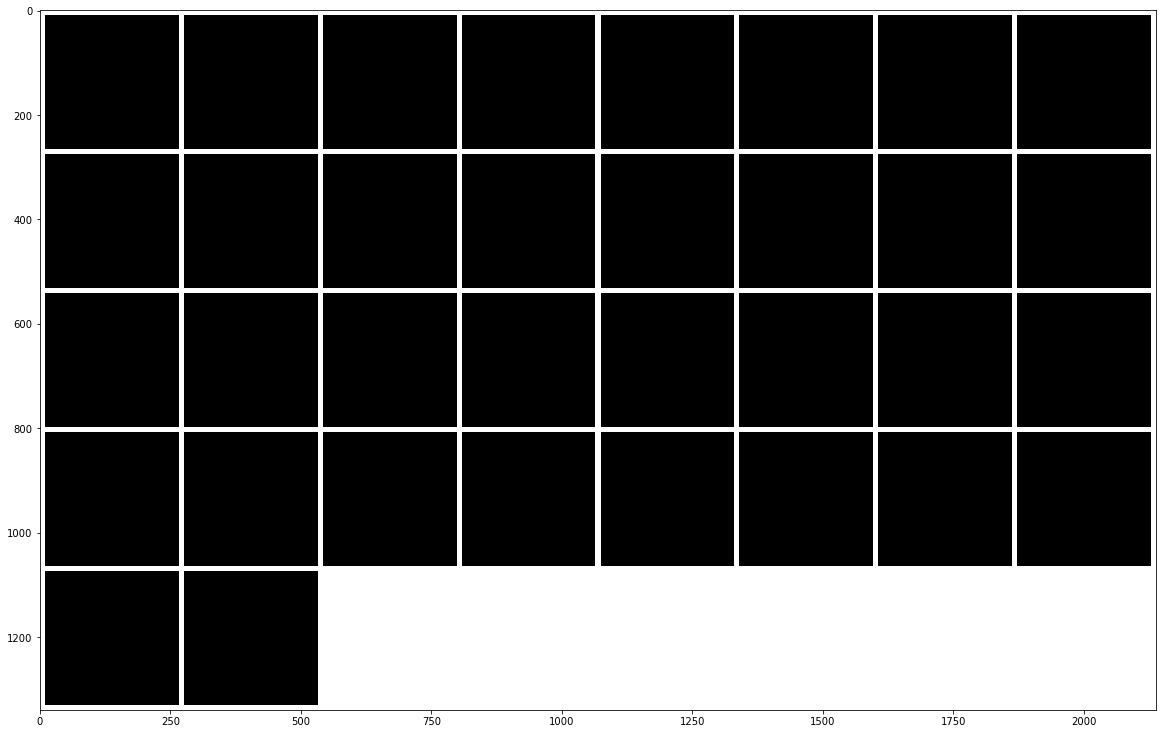

----------------------------------------------------------------------------------------------------
Ground Truth


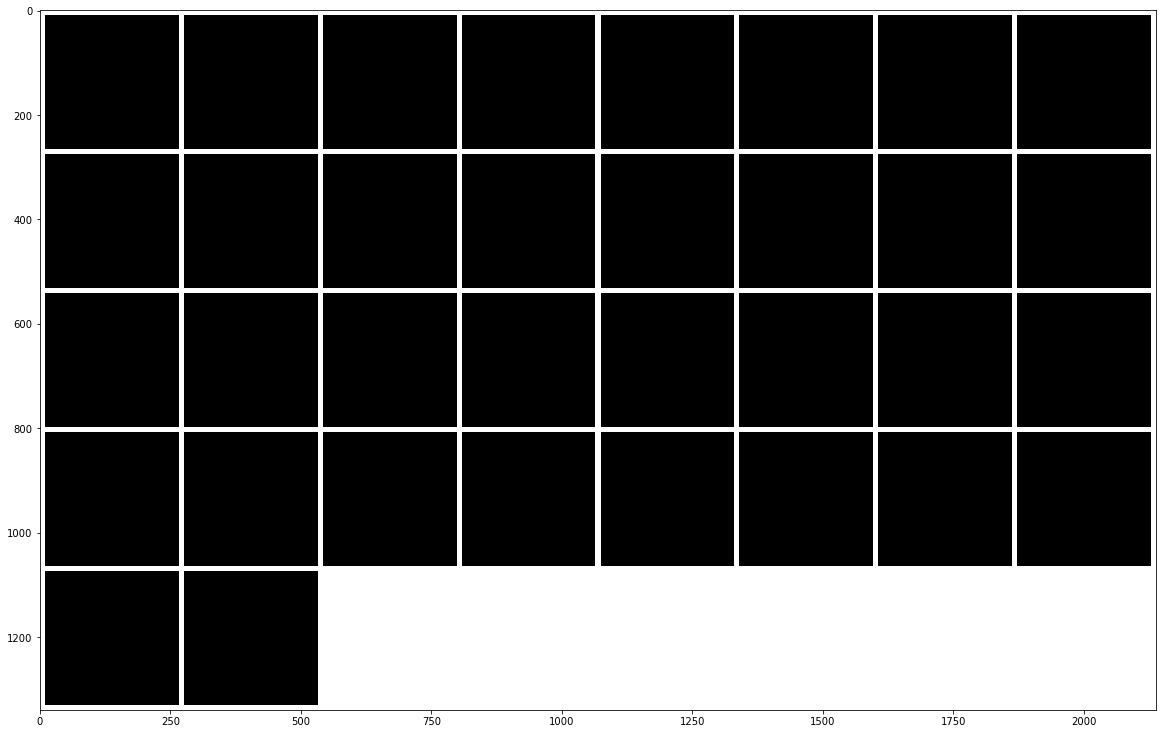

----------------------------------------------------------------------------------------------------
Prediction


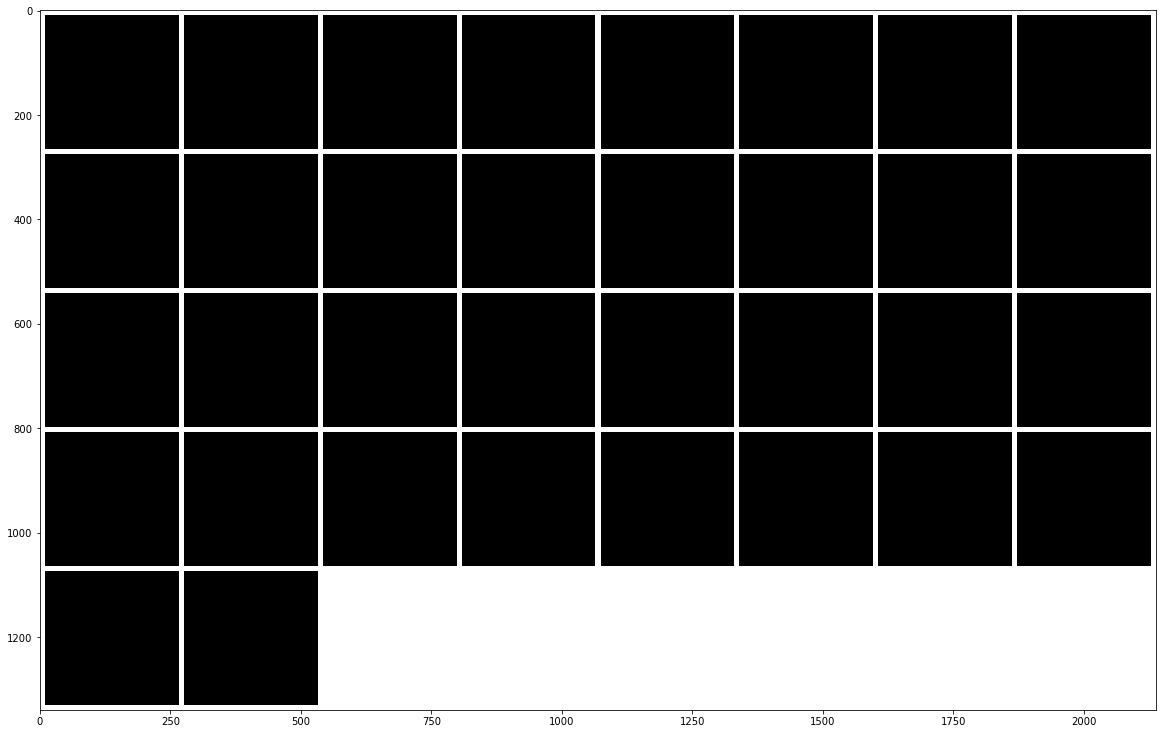

----------------------------------------------------------------------------------------------------
Ground Truth


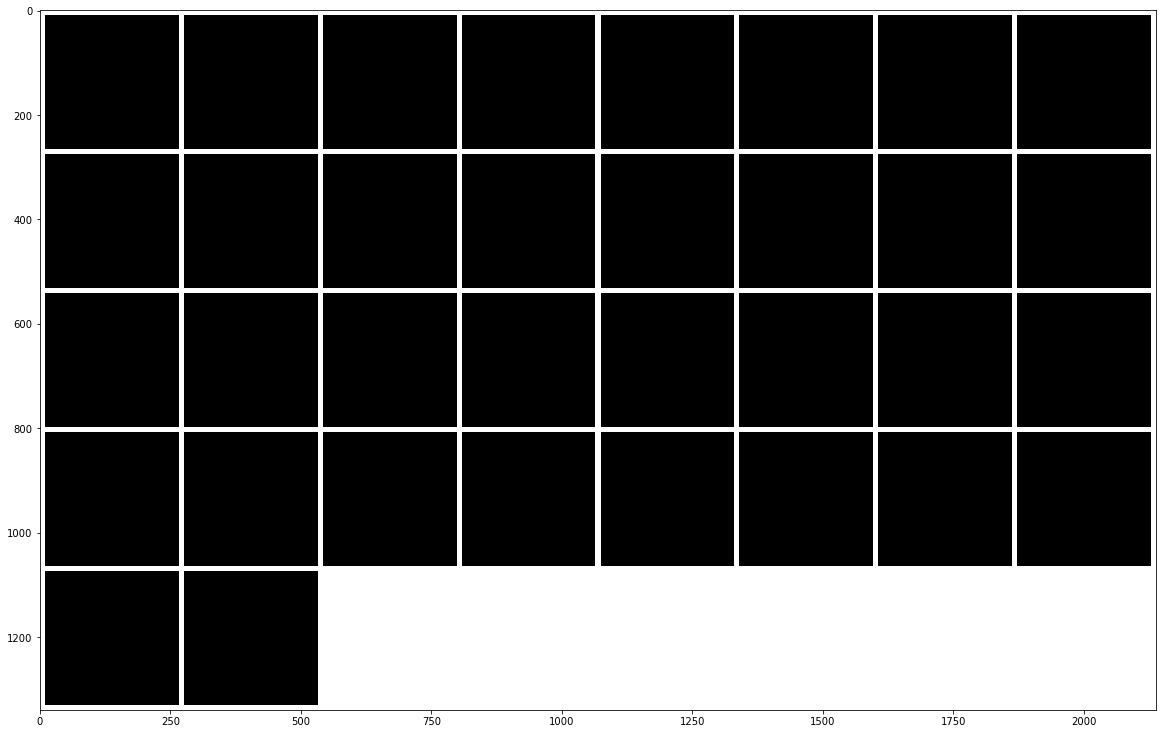

----------------------------------------------------------------------------------------------------
Prediction


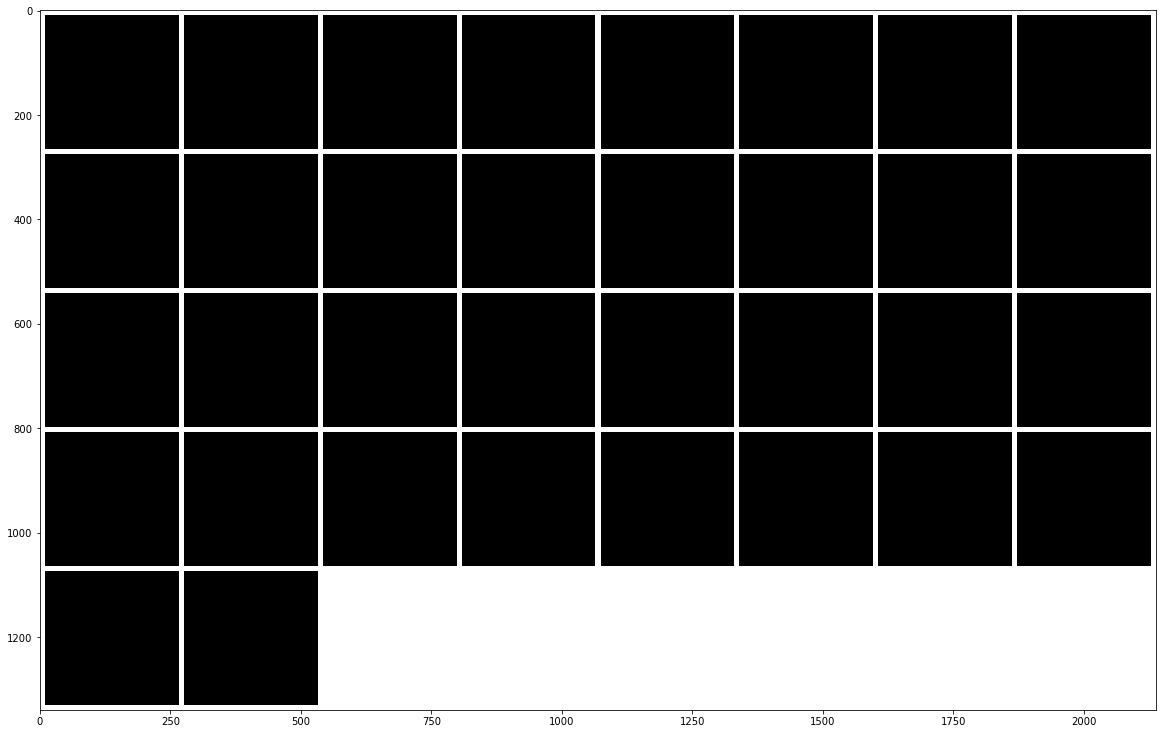

----------------------------------------------------------------------------------------------------
Ground Truth


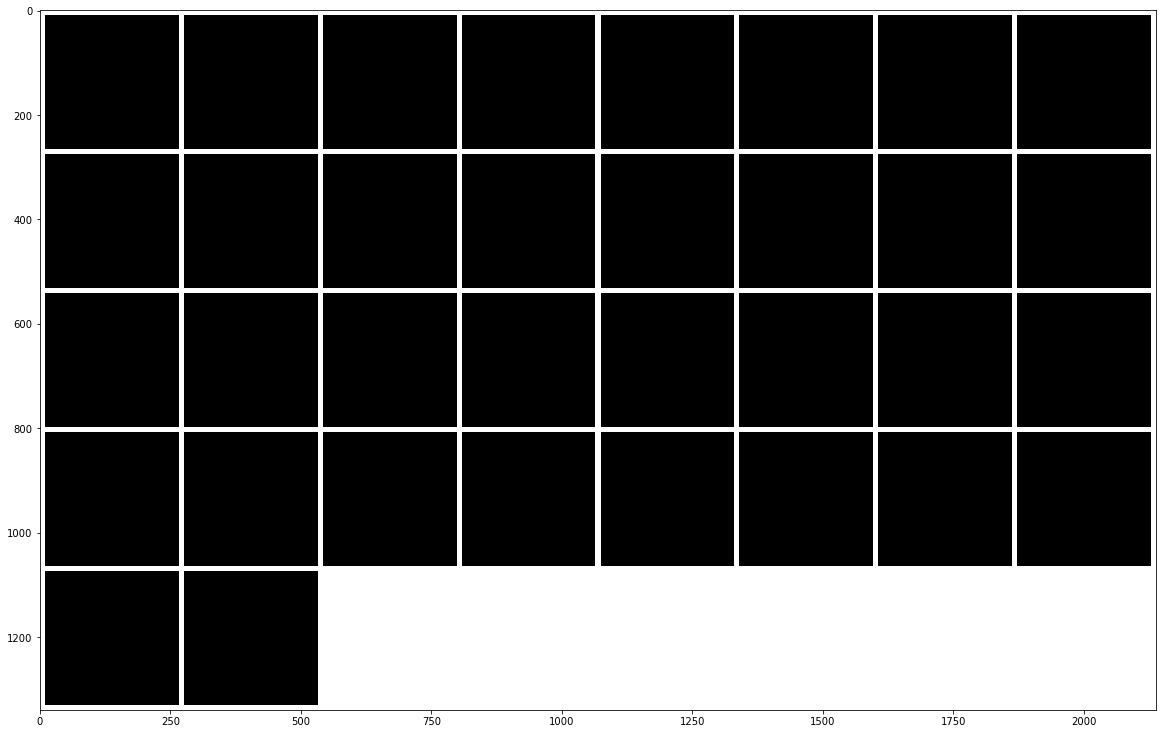

----------------------------------------------------------------------------------------------------
Prediction


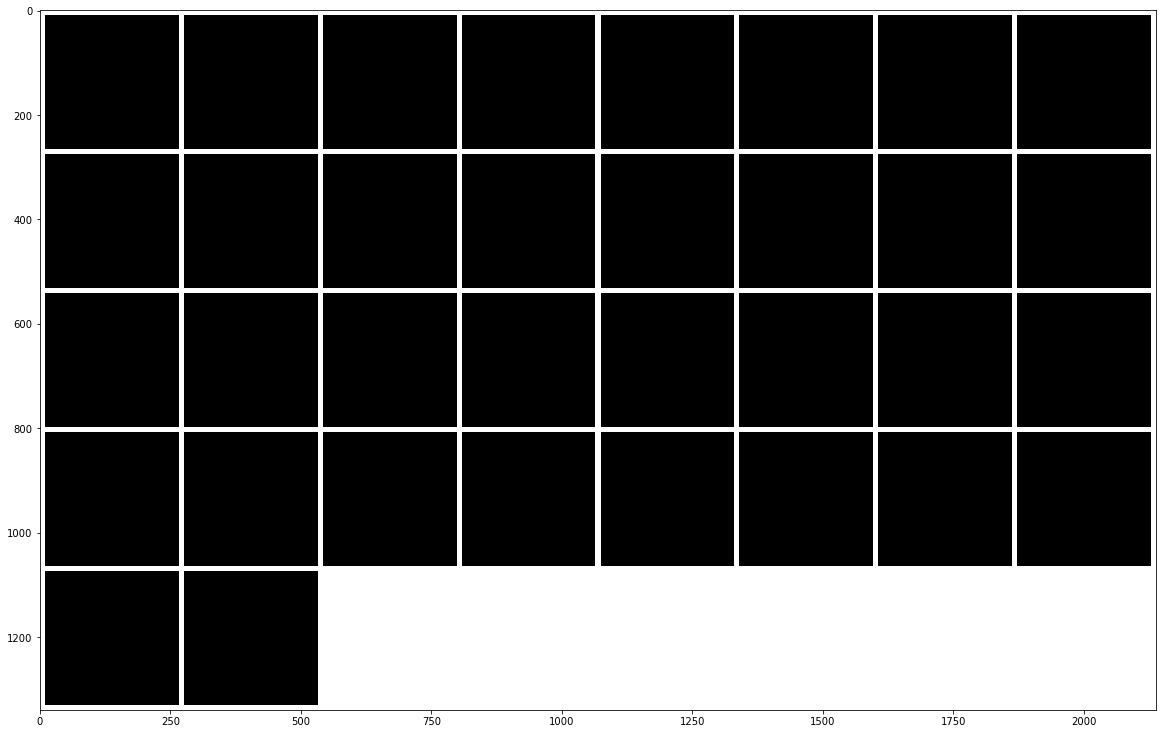

----------------------------------------------------------------------------------------------------
Ground Truth


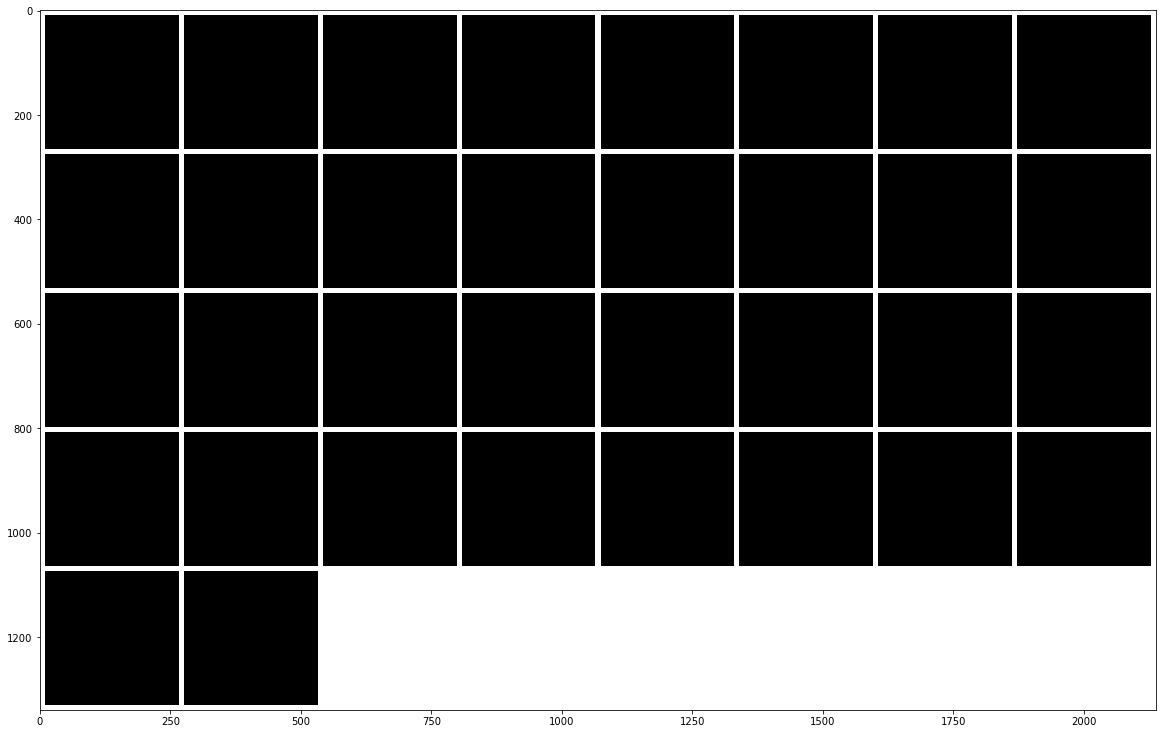

----------------------------------------------------------------------------------------------------
Prediction


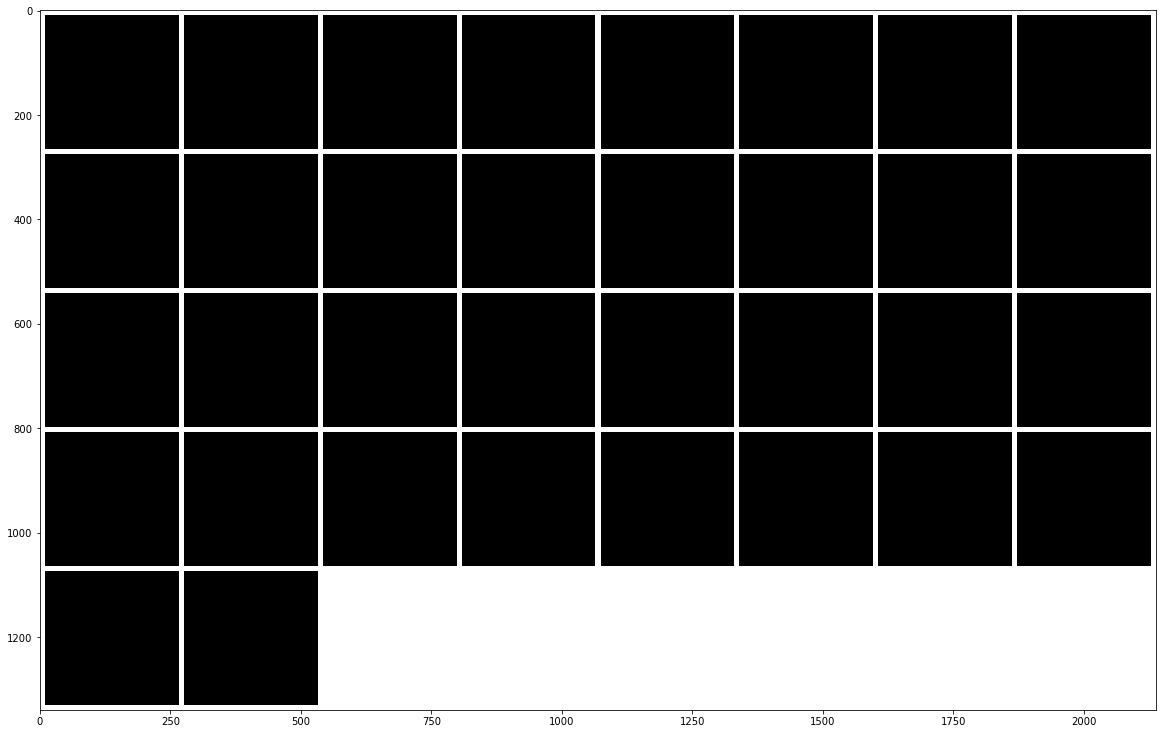

In [41]:
visualize_few()